In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib
import scipy
import sklearn
import networkx
import seaborn
import brian2
import allensdk
import mcmodels


library_versions = {
    'Python': sys.version,
    'NumPy': np.__version__,
    'Pandas': pd.__version__,
    'Matplotlib': matplotlib.__version__,
    'SciPy': scipy.__version__,
    'Scikit-learn': sklearn.__version__,
    'Networkx': networkx.__version__,
    'Seaborn': seaborn.__version__,
    'Brian2': brian2.__version__,
    'AllenSDK': allensdk.__version__,
    'Mcmodels': mcmodels.__version__
}
library_versions

WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
 [py.warnings]
WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
 [py.warnings]


{'Python': '3.6.7 | packaged by conda-forge | (default, Feb 28 2019, 02:16:08) \n[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]',
 'NumPy': '1.18.5',
 'Pandas': '0.25.3',
 'Matplotlib': '3.3.4',
 'SciPy': '1.2.0',
 'Scikit-learn': '0.22',
 'Networkx': '2.5',
 'Seaborn': '0.11.1',
 'Brian2': '2.2',
 'AllenSDK': '1.5.1',
 'Mcmodels': '0.0.1'}

In [2]:
# make figures

In [3]:
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import brian2
import pickle
# from matplotlib import colors

from adjustText import adjust_text

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['svg.fonttype'] = 'none'

In [4]:
# load arealist
area_list = list(np.loadtxt('results/area_list.csv', delimiter=',', dtype='str'))

# load connectivity 
conn_cxcx = np.loadtxt('results/conn_cxcx.csv', delimiter=',')

# load interneuron density
normPVgrad_df = pd.read_csv('results/dfPV.csv', header = 0, index_col=0)

rawPV_df = pd.read_csv('results/dfPVraw.csv', header = 0, index_col=0)

# load hierarchy
hierarchy_df = pd.read_csv('results/dfHier.csv', header=0, index_col=0)

# load model
with open('results/model_V1.pkl', 'rb') as f:
    model = pickle.load(f)

with open('results/model_V1_PVconstant.pkl', 'rb') as f:
    modelAveragePV = pickle.load(f)

with open('results/model_V1_noCIB.pkl', 'rb') as f:
    modelAveragePref = pickle.load(f)


with open('results/model_V1_Alt.pkl', 'rb') as f:
    modelAlternative = pickle.load(f)

with open('results/model_V1_Alt_PVconstant.pkl', 'rb') as f:
    modelAlternativeAveragePV = pickle.load(f)

with open('results/model_V1_Alt_noCIB.pkl', 'rb') as f:
    modelAlternativeAveragePref = pickle.load(f)


with open('results/model_V1_allcore.pkl', 'rb') as f:
    modelAllcore = pickle.load(f)


In [5]:
def plotDynamics(model, plotAreaList, Yaxis, sameYaxisLimit, lineWidth, figureSize, fontSize, saveFig, fileName):
    
    # generate figures for specific areas. # sixplots
    start = model.parameters['stim_on']
    plot_start_time = 0.5
    plot_end_time = model.trial_length/brian2.second -0.5
#     plot_end_time = start/brian2.second + 4
    dt = model.dt
    plt.figure(figsize=figureSize)
    
    k = 1
    # Plot the rates for E1&E2
    plt.rcParams.update({'font.size':fontSize})
    
    popNo = 0
    if Yaxis == 'FR':
        Y = model.R
        yLabel = 'Rate (Hz)'
        popNo = 0
    elif Yaxis == 'localCurrent':
        Y = model.I_local_NMDA * 10**9
        yLabel = 'Local NMDA \n current (nA)'
        popNo = 0
    elif Yaxis == 'LRECurrent':
        Y = model.I_LR_NMDA * 10**9
        yLabel = 'Long range \n current to E (nA)'
        popNo = 0
    elif Yaxis == 'LRICurrent':
        Y = model.I_LR_NMDA * 10**9
        yLabel = 'Long range \n current to I (nA)'
        popNo = 2
    elif Yaxis == 'synaptic':
        Y = model.S_NMDA
        yLabel = 'synaptic variable \n  NMDA'
        popNo = 0

    else:
        raise ValueError('Yaxis value error.')
        return
    #get Y max
    
    Ymax = 0
    for i in plotAreaList:
        Ymax = max(Ymax, 1.2 * np.max(Y[:,i-1,popNo]))
    
    X = np.arange(plot_start_time*brian2.second - start, plot_end_time*brian2.second - start, dt)
    for i in plotAreaList:
        plt.subplot(2,3,k)
        ax = plt.gca()
        # plot the firing of first pop
        ax.plot(X, Y[np.arange(int(plot_start_time/dt), int(plot_end_time/dt), 1), i-1, popNo],
                 color='#3C5488FF', linewidth=lineWidth)

        # plot the firing of second pop
        if model.parameters['distractionInput']:
            ax.plot(X, Y[np.arange(int(plot_start_time/dt), int(plot_end_time/dt), 1), i-1, 1],
                 color='orange', linewidth=lineWidth)

        if sameYaxisLimit:
            plt.ylim((0, Ymax))
            if Yaxis == 'synaptic':
                plt.ylim((-0.1, 1.1))

        # Plot the stimulation duration bar
        if plot_end_time<25:
            if sameYaxisLimit:
                Ypos = Ymax * 1.1 / 1.2
            else:
                Ypos = 1.1 * np.max(Y[:,i-1,popNo])
            ax.plot([model.stim_on - start, model.stim_off - start], [Ypos, Ypos],
                     color='black', linewidth=lineWidth)
            if model.parameters['distractionInput']:
                ax.plot([model.parameters['distract_on'] - start, model.parameters['distract_off'] - start], [Ypos, Ypos],
                     color='green', linewidth=lineWidth)
                
#             if model.parameters['thcxmodel']:
#                 ax.plot([model.parameters['inh_stim_on'] - start, model.parameters['inh_stim_off'] - start], [Ypos, Ypos],
#                      color='blue', linewidth=lineWidth)
        
        plt.title(model.area_list[i-1])
        # hide the frames
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        plt.setp(ax.spines.values(), linewidth=lineWidth)

        if k >= 4:
            plt.xlabel('Time (s)')
        if k%3 == 1:
            plt.ylabel(yLabel)
            
        # add shade to inhibition.

    #     if inh_multiarea != None:
    #         for j in np.arange(len_inhmulti):
    #             if area_list[i-1] == inh_multiarea[j]:
    #                 plt.axvspan(inhibition_on,inhibition_off,facecolor='b',alpha=0.1)  

        k+= 1
    
    plt.tight_layout()
    if saveFig:
        plt.savefig('figure/' + fileName, dpi=300, bbox_inches='tight', transparent=True)

In [6]:
def plotDynamicsTwo(modelList, plotAreaList, colorList, labelList, Yaxis, sameYaxisLimit, lineWidth, figureSize, fontSize, saveFig, fileName):
    
    model1, model2 = modelList

    if len(modelList) != len(colorList):
        raise ValueError('modelList and colorList must have the same length.')
        return

    # generate figures for specific areas. # sixplots
    if model1.parameters['stim_on'] != model2.parameters['stim_on']:
        raise ValueError('stim_on is not the same in two models.')
        return
    start = model1.parameters['stim_on']
    plot_start_time = 0.5
    if model1.trial_length != model2.trial_length:
        raise ValueError('trial_length is not the same in two models.')
        return
    plot_end_time = model1.trial_length/brian2.second -0.5
#     plot_end_time = start/brian2.second + 4
    if model1.dt != model2.dt:
        raise ValueError('dt is not the same in two models.')
        return
    dt = model1.dt
    plt.figure(figsize=figureSize)
    
    k = 1
    # Plot the rates for E1&E2
    plt.rcParams.update({'font.size':fontSize})
    
    popNo = 0
    if Yaxis == 'FR':
        Ylist = [x.R for x in modelList]
        yLabel = 'Rate (Hz)'
        popNo = 0
    elif Yaxis == 'localCurrent':
        Ylist = [x.I_local_NMDA for x in modelList]
        yLabel = 'Local NMDA \n current'
        popNo = 0
    elif Yaxis == 'LRECurrent':
        Ylist = [x.I_LR_NMDA for x in modelList]
        yLabel = 'Long range \n current to E'
        popNo = 0
    elif Yaxis == 'LRICurrent':
        Ylist = [x.I_LR_NMDA for x in modelList]
        yLabel = 'Long range \n current to I'
        popNo = 2
    elif Yaxis == 'synaptic':
        Ylist = [x.S_NMDA for x in modelList]
        yLabel = 'synaptic variable \n  NMDA'
        popNo = 0
    else:
        raise ValueError('Yaxis value error.')
        return
    #get Y max
    
    Y1, Y2 = Ylist[0], Ylist[1]

    Ymax = 0
    for i in plotAreaList:
        for y in Ylist:
            Ymax = max(Ymax, 1.2 * np.max(y[:,i-1,popNo]))

    
    X = np.arange(plot_start_time*brian2.second - start, plot_end_time*brian2.second - start, dt)
    for i in plotAreaList:
        plt.subplot(2,3,k)
        ax = plt.gca()
        # plot the firing of first pop
        for j in range(len(Ylist)):
            y = Ylist[j]
            ax.plot(X, y[np.arange(int(plot_start_time/dt), int(plot_end_time/dt), 1), i-1, popNo],
                     color=colorList[j], linewidth=lineWidth, label=labelList[j]) # '#3C5488FF'
        
        # plot the firing of second pop # TODO need to change the code; does not work for distractionInput.
        if model1.parameters['distractionInput'] or model2.parameters['distractionInput']:
            for y in Ylist:
                ax.plot(X, y[np.arange(int(plot_start_time/dt), int(plot_end_time/dt), 1), i-1, 1],
                     color='orange', linewidth=lineWidth)    

        if sameYaxisLimit:
            plt.ylim((0, Ymax))
            
        # Plot the stimulation duration bar
        if plot_end_time<25:
            Ypos = Ymax * 1.1 / 1.2
            ax.plot([model2.stim_on - start, model2.stim_off - start], [Ypos, Ypos],
                     color='black', linewidth=lineWidth)
            if model1.parameters['distractionInput']:
                ax.plot([model1.parameters['distract_on'] - start, model1.parameters['distract_off'] - start], [Ypos, Ypos],
                     color='green', linewidth=lineWidth)
            if model2.parameters['distractionInput']:
                ax.plot([model2.parameters['distract_on'] - start, model2.parameters['distract_off'] - start], [Ypos, Ypos],
                     color='green', linewidth=lineWidth)
            
            if model1.parameters['inhibitoryInput']:
                ax.plot([model1.parameters['inh_stim_on'] - start, model1.parameters['inh_stim_off'] - start], [Ypos, Ypos],
                     color='blue', linewidth=lineWidth)
            if model2.parameters['inhibitoryInput']:
                ax.plot([model2.parameters['inh_stim_on'] - start, model2.parameters['inh_stim_off'] - start], [Ypos, Ypos],
                     color='blue', linewidth=lineWidth)
        
        plt.title(model1.area_list[i-1])
        # hide the frames
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        plt.setp(ax.spines.values(), linewidth=lineWidth)

        if k >= 4:
            plt.xlabel('Time (s)')
        if k%3 == 1:
            plt.ylabel(yLabel)
            
        # add shade to inhibition.

    #     if inh_multiarea != None:
    #         for j in np.arange(len_inhmulti):
    #             if area_list[i-1] == inh_multiarea[j]:
    #                 plt.axvspan(inhibition_on,inhibition_off,facecolor='b',alpha=0.1)  

        k+= 1

    # add legend
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper center')

    plt.tight_layout()
    if saveFig:
        plt.savefig('figure/' + fileName, dpi=300, bbox_inches='tight', transparent=True)

In [7]:
ROIlist = [0,26,30,31,36, 38]
[area_list[i] for i in ROIlist]

['VISp', 'ILA', 'ORBm', 'PL', 'VISa', 'MOs']

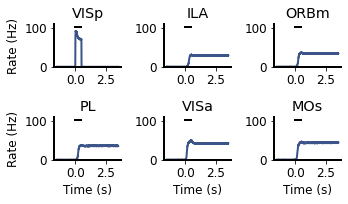

In [8]:
plotAreaList = [i+1 for i in ROIlist]  # VISp stimulus
# plot firing rates for sample areas
plotDynamics(model, plotAreaList, 'FR', True, 2, (5,3), 12, True, 'makeFigures/dynamicsPlot.svg')

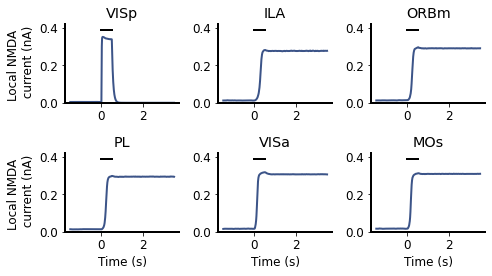

In [9]:
# plot local NMDA current for sample areas
plotDynamics(model, plotAreaList, 'localCurrent', True, 2, (7,4), 12, True, 'makeFigures/currentPlot.svg')

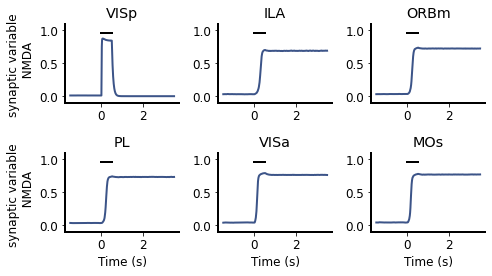

In [10]:
# make plots of synaptic variables sNMDA
plotDynamics(model, plotAreaList, 'synaptic', True, 2, (7,4), 12, True, 'makeFigures/sNMDAPlot.svg')

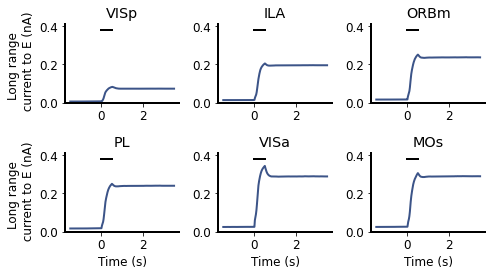

In [11]:
# make plots of synaptic variables sNMDA
# plotDynamics(model, [1,22,31,32,33, 43], 'LRECurrent', True, 2, (7,4), 12, True, 'makeFigures/LREcurrentPlot.svg')

plotDynamics(model, plotAreaList, 'LRECurrent', True, 2, (7,4), 12, True, 'makeFigures/LREcurrentPlot.svg')

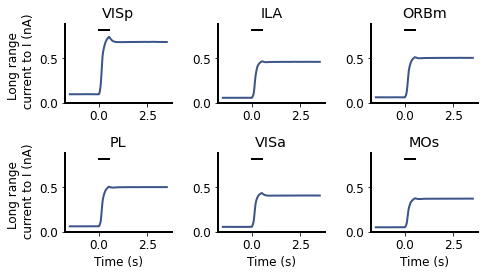

In [12]:
# make plots of synaptic variables sNMDA
# plotDynamics(model, [1,22,31,32,33, 43], 'LRICurrent', True, 2, (7,4), 12, True, 'makeFigures/LRIcurrentPlot.svg')
plotDynamics(model, plotAreaList, 'LRICurrent', True, 2, (7,4), 12, True, 'makeFigures/LRIcurrentPlot.svg')


In [13]:
# plt.plot(modelnlr.S_NMDA[:, 0, 0])
# plt.figure()
# plt.plot(modelnlr.S_GABA[:, 0, 2])
# print(modelnlr.S_GABA.shape, modelnlr.n_areas)


In [14]:
# plt.plot(modelnlr.S_NMDA[np.arange(int(plot_start_time/p['dt']), int(plot_end_time/p['dt']), 1), 0, 0])
# plt.figure()
# plt.plot(modelnlr.S_GABA[np.arange(int(plot_start_time/p['dt']), int(plot_end_time/p['dt']), 1), 0, 2])

KeyError: 'distractionInput'

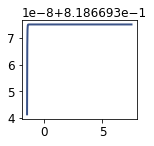

In [15]:
# quick check sNMDA
with open('results/model_V1_noLR_noInh_zeronoise_ISN.pkl', 'rb') as f:
    modelnlr = pickle.load(f)
# make plots of synaptic variables sNMDA
plotDynamics(modelnlr, plotAreaList,'synaptic', True, 2, (7,4), 12, False, 'ISN/sNMDAPlot.svg')

In [457]:
0.74 * 0.5
# 0.35* 0.5

0.37

In [16]:
# mmee

# load noLR model
# with open('results/model_V1_noLR_zeronoise.pkl', 'rb') as f:
#     modelnlr = pickle.load(f)
# with open('results/model_V1_noLR_noInh_zeronoise.pkl', 'rb') as f:
#     modelnlr = pickle.load(f)

with open('results/model_V1_noLR_zeronoise_ISN.pkl', 'rb') as f:
    modelnlr = pickle.load(f)
# with open('results/model_V1_noLR_noInh_zeronoise_ISN.pkl', 'rb') as f:
#     modelnlr = pickle.load(f)


# define paramters that are useful.
p = modelnlr.parameters
# get baseline synaptic variable. 
plot_start_time = 8
plot_end_time = 9

# mm222
p['g_E_I'] = 0.74 * 0.5 * brian2.nA  # saddle node1  0.175nA    saddle node2 0.37nA


k = 6 # V1 index    SSp-n: 4   AIp:6
# geeV = p['g_E_self'] * modelnlr.local_EE_gradient[k][0]
geeV = p['g_E_self'] * modelnlr.local_EE_gradient[k][0]


# setting geeV to 1.5 or more fold to see the effect of local excitation
# geeV = 1.5 * p['g_E_self'] * modelnlr.local_EE_gradient[k][0]



geeCrossV = p['g_E_cross']

geiV = p['g_E_I'] * modelnlr.local_EI_gradient[k][0]
# setting geiV to 0 to see the effect of local inhibition
# geiV = 0

gieV = p['g_I_E'] * modelnlr.local_IE_gradient[k][0]
giiV = p['g_Iself'] * modelnlr.local_II_gradient[k][0]

# p['I0_E_mean'] = 1.5 * p['I0_E_mean']

# printout the baseline synaptic variable from simulation.
saStar = np.mean(modelnlr.S_NMDA[np.arange(int(plot_start_time/p['dt']), int(plot_end_time/p['dt']), 1), k, 0])
sbStar = np.mean(modelnlr.S_NMDA[np.arange(int(plot_start_time/p['dt']), int(plot_end_time/p['dt']), 1), k, 1])
scStar = np.mean(modelnlr.S_GABA[np.arange(int(plot_start_time/p['dt']), int(plot_end_time/p['dt']), 1), k, 2])
print('area', modelnlr.area_list[k], 'saStar', saStar, 'sbStar', sbStar, 'scStar', scStar)
print('gEI', p['g_E_I'])

area AIp saStar 0.028759214937249148 sbStar 0.028759214937249148 scStar 0.03077068376348285
gEI 0.37 nA


In [17]:
# ItotalG calculated
ItotalGcalc = gieV * saStar + gieV * sbStar - giiV * scStar + p['I0_I']
print(ItotalGcalc)
# RG calculated
phiIcalc =1/p['g_2'] * (p['c_I'] * (gieV * saStar + gieV * sbStar - giiV * scStar + p['I0_I']) - p['c_0'] ) + p['r0_I']
print(phiIcalc)
# calculate dsc/dt
-scStar/ p['tau_GABA'] + p['gamma_GABA'] * phiIcalc
# calculate sc
p['tau_GABA'] * p['gamma_GABA'] * phiIcalc

# # real simulation Itotal
# np.mean(modelnlr.I_total[np.arange(int(plot_start_time/p['dt']), int(plot_end_time/p['dt']), 1), k, 2])
# # real simulation R
# np.mean(modelnlr.R[np.arange(int(plot_start_time/p['dt']), int(plot_end_time/p['dt']), 1), k, 2])

272.04597318 pA
3.07706838 Hz


0.030770683763482864

In [18]:
import sympy
from sympy import symbols, diff, exp, lambdify
from scipy.optimize import fsolve


# Define the variables
sa, sb, sc, tauN, gamma, gee, geeCross, gei, I0a, a, b, d = symbols('sa sb sc tauN gamma gee geeCross gei I0a a b d')
tauG, gammaI, gI, c1, gie, gii, I0c, c0, r0 = symbols('tauG gammaI gI c1 gie gii I0c c0 r0')

# Define the function phi
phiA = (a * (gee * sa + geeCross * sb - gei * sc + I0a) - b) / (1 - exp(-d * (a * (gee * sa + geeCross * sb - gei * sc + I0a) - b)))
phiB = (a * (gee * sb + geeCross * sa - gei * sc + I0a) - b) / (1 - exp(-d * (a * (gee * sb + geeCross * sa - gei * sc + I0a) - b)))
phiI = 1/gI * (c1 * (gie * sa + gie * sb - gii * sc + I0c) - c0 ) + r0

# Define the function F G
FA = -sa / tauN + gamma * (1 - sa) * phiA
FB = -sb / tauN + gamma * (1 - sb) * phiB
G = -sc/ tauG + gammaI * phiI

# Compute the partial derivatives
FA_sa = diff(FA, sa)
FA_sb = diff(FA, sb)
FA_sc = diff(FA, sc)

FB_sa = diff(FB, sa)
FB_sb = diff(FB, sb)
FB_sc = diff(FB, sc)

G_sa = diff(G, sa)
G_sb = diff(G, sb)
G_sc = diff(G, sc)

# define values for parameters, except sa, sb, sc.
values_nonSaSc = {
    tauN: p['tau_NMDA'],
    gamma: p['gamma_NMDA'],
    gee: geeV,
    geeCross: geeCrossV,
    gei: geiV,
    I0a: p['I0_E_mean'],
    a: p['a_E'],
    b: p['b_E'],
    d: p['d_E'],
    
    tauG: p['tau_GABA'],
    gammaI: p['gamma_GABA'],
    gI: p['g_2'],
    c1: p['c_I'],
    gie: gieV,
    gii: giiV,
    I0c: p['I0_I'],
    c0: p['c_0'],
    r0: p['r0_I']
}

In [19]:
# solve the fixed value. 

# solve the system
FA_sub = FA.subs(values_nonSaSc)
FB_sub = FB.subs(values_nonSaSc)
G_sub = G.subs(values_nonSaSc)

sc_sub = sympy.solve(G_sub, sc)
sc_sub = sc_sub[0].subs({sb:sa}) # assuming sb = sa
FA_eq = FA_sub.subs({sb:sa, sc:sc_sub})

In [20]:
print(FA_eq)

-16.6666666666667*sa + 1.282*(1 - sa)*(49.0723671097239*sa - 11.8463488134316)/(1 - 38.4237375716781*exp(-15.114289069795*sa))


In [21]:
# inputStr should match what printed out from print(FA_eq)
inputStr = '-16.6666666666667*sa + 1.282*(1 - sa)*(49.0723671097239*sa - 11.8463488134316)/(1 - 38.4237375716781*exp(-15.114289069795*sa))'
inputStr = inputStr.replace('sa', 'saArrXXGEI').replace('exp', 'np.exp')
print(inputStr)

-16.6666666666667*saArrXXGEI + 1.282*(1 - saArrXXGEI)*(49.0723671097239*saArrXXGEI - 11.8463488134316)/(1 - 38.4237375716781*np.exp(-15.114289069795*saArrXXGEI))


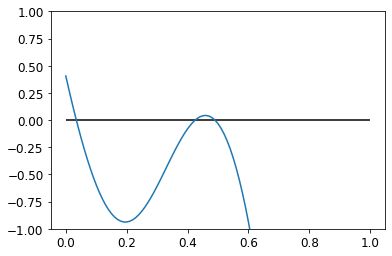

In [22]:
# XX * GEI: plot the equation of FA and check the position of zero point.
saArrXXGEI = np.arange(0, 1, 0.01)  # sa is changed
# replace the formula with what printed out from inputStr
FA_calcEQ_XXGEI = -16.6666666666667*saArrXXGEI + 1.282*(1 - saArrXXGEI)*(49.0723671097239*saArrXXGEI - 11.8463488134316)/(1 - 38.4237375716781*np.exp(-15.114289069795*saArrXXGEI))
plt.plot(saArrXXGEI, FA_calcEQ_XXGEI)
plt.ylim([-1, 1])
plt.hlines(0, 0, 1, color='k')

In [23]:
# Convert the SymPy expression to a function
fa_expr = lambdify(sa, FA_eq)
print(fa_expr)

# Use fsolve to find the root
initial_guess = 1
root = fsolve(fa_expr, initial_guess)
saStar = float(root[0])
# always double check if the root is a zero point or just close to zero. 
va = FA_eq.subs({sa:saStar})
print(va)
if abs(va) < 1e-6:
    print("The saStar is", saStar)
    sbStar = float(saStar)
    print("The sbStar is", sbStar)
    scStar = float(sc_sub.subs({sa:saStar}))
    print("The scStar is", scStar)
else:
    print("Zero point not found.")

<function _lambdifygenerated at 0x7fe4f93120d0>
1.24344978758018e-14
The saStar is 0.4900058146868525
The sbStar is 0.4900058146868525
The scStar is 0.3551181608748179


In [24]:
# # 1* GEE no inh: plot the equation of FA and check the position of zero point.
# print(FA_eq)
# saArr1GEE = np.arange(0, 1, 0.01)
# FA_calcEQ_1GEE = - 16.6666666666667 * saArr1GEE + 1.282 * (1 - saArr1GEE) * (57.498 * saArr1GEE - 11.3) / (1 - 32.4727085618182 * np.exp(-17.709384 * saArr1GEE) )

# plt.plot(saArr1GEE, FA_calcEQ_1GEE)
# plt.ylim([-1, 1])
# plt.hlines(0, 0, 1, color='k')

In [25]:
# # 1.5 GEE no inh: plot the equation of FA and check the position of zero point.
# print(FA_eq)

# saArr = np.arange(0, 1, 0.01)
# FA_rawEQ = - 16.6666666666667 * saArr + 1.282 * (1 - saArr) * (85.498 * saArr - 11.3) / (1 - 32.4727085618182 * np.exp(-26.333384 * saArr) )
# plt.plot(saArr, FA_rawEQ)
# plt.ylim([-1, 1])
# plt.hlines(0, 0, 1, color='k')

In [26]:
# pre requirement: test if preQ1 and preQ2 are larger than 0
# (𝑎(𝑔_𝐸𝐸 𝑆_𝐴+𝑔_𝐸𝐼 𝑆_𝐶+𝐼_0𝐴 )−𝑏)>0   and  (1/𝑔_𝐼 (𝑐_1 (〖2𝑔〗_𝐼𝐸 𝑆_𝐴+𝑔_𝐼𝐼 𝑆_𝐶+𝐼_0𝐶 )−𝑐_0)+𝑟_0) > 0
preQ1 = p['a_E'] *  (geeV * saStar + geeCrossV * sbStar - geiV * scStar + p['I0_E_mean']) - p['b_E']
preQ2 = 1 / p['g_2'] * (p['c_I'] * (2 * gieV * saStar - giiV * scStar + p['I0_I']) - p['c_0']) + p['r0_I']
print('check if both are larger than 0? ', preQ1, preQ2)

check if both are larger than 0?  12.19939641 Hz 35.51181609 Hz


In [27]:
# define the values
values = {
    sa: saStar,
    sb: sbStar,
    sc: scStar,
    tauN: p['tau_NMDA'],
    gamma: p['gamma_NMDA'],
    gee: geeV,
    geeCross: geeCrossV,
    gei: geiV,
    I0a: p['I0_E_mean'],
    a: p['a_E'],
    b: p['b_E'],
    d: p['d_E'],
    tauG: p['tau_GABA'],
    gammaI: p['gamma_GABA'],
    gI: p['g_2'],
    c1: p['c_I'],
    gie: gieV,
    gii: giiV,
    I0c: p['I0_I'],
    c0: p['c_0'],
    r0: p['r0_I']
    
}

In [28]:
# substitute the values for the derivatives
dfadsa = FA_sa.subs(values)
dfadsb = FA_sb.subs(values)
dfadsc = FA_sc.subs(values)

dfbdsa = FB_sa.subs(values)
dfbdsb = FB_sb.subs(values)
dfbdsc = FB_sc.subs(values)

dgdsa = G_sa.subs(values)
dgdsb = G_sb.subs(values)
dgdsc = G_sc.subs(values)

In [29]:
# calculate raStar, rbStar, rcStar
raStar = phiA.subs(values)
print("The raStar is", raStar)
rbStar = phiB.subs(values)
print("The rbStar is", rbStar)
rcStar = phiI.subs(values)
print("The rcStar is", rcStar)

The raStar is 12.4909863437634
The rbStar is 12.4909863437634
The rcStar is 35.5118160874818


In [30]:
# calculate jacobian matrix and eigenvalues
matr = [[float(dfadsa), float(dfadsb), float(dfadsc)],
        [float(dfbdsa), float(dfbdsb), float(dfbdsc)],
          [float(dgdsa), float(dgdsb), float(dgdsc)]]
matr = np.array(matr)
print(matr)
eigenvalues, _ = np.linalg.eig(matr)
print(eigenvalues)

[[  18.50258138    0.91275802  -31.5626604 ]
 [   0.91275802   18.50258138  -31.5626604 ]
 [  81.672        81.672      -232.2875    ]]
[-209.79472116   -3.07743944   17.58982337]


In [31]:
noLabelAreas = ['SSp-ll','SSp-ul','SSp-n','SSp-m','SSp-tr','VISli','VISpl','VISrl','RSPd','AUDv','SSs']

In [32]:
def plotFRvsPVnotebook(model, annotation_adjust, showLabel,noLabelAreas, dotSize, figureSize, fontSize, saveFig, fileName):

    persistentact_df = model.persistentact_df
    persistentact_df_sort = persistentact_df.sort_values(by='PVdensity').reset_index(drop=True)

    div = model.parameters['div']
    div_name_list = model.parameters['div_name_list']
    div_color_list = model.parameters['div_color_list']

    fig = plt.figure(figsize=figureSize, dpi=300, facecolor='w', edgecolor='k')
    plt.rcParams.update({'font.size': fontSize})
    # plot FR vs hierarchy
    plt.scatter(persistentact_df_sort['PVdensity'], persistentact_df_sort['persistentact'],
                s=dotSize)
    ax = plt.gca()
    # plt.ylim(-6.5,65) # leave enough space for annotation.
    # add annotation text
    if showLabel:
        texts = []
        xPos = []
        yPos = []
        for i in range(model.n_areas):
            acr = persistentact_df_sort['Acronym'][i]
            if acr in model.area_list:
                for div_name, div_color in zip(div_name_list, div_color_list):
                    if acr in div[div_name] and acr not in noLabelAreas:
                        xPos += persistentact_df_sort['PVdensity'][i]
                        yPos += persistentact_df_sort['persistentact'][i]                      
                        texts += [ax.text(persistentact_df_sort['PVdensity'][i],
                                          persistentact_df_sort['persistentact'][i], acr,
                                          color=div_color, fontsize=fontSize*0.6)]

        # # use adjust library to adjust the position of annotations.
        if annotation_adjust:
            adjust_text(texts, xPos, yPos,
                        ax=ax, precision=0.001,
                        arrowprops=dict(arrowstyle='-', color='gray', alpha=.3))
#         if annotation_adjust:
#             adjust_text(texts, persistentact_df_sort['PVdensity'], persistentact_df_sort['persistentact'],
#                         ax=ax, precision=0.001,
#                         expand_text=(1.01, 1.05), expand_points=(1.01, 1.05),
#                         force_text=(0.01, 0.25), force_points=(0.01, 0.25),
#                         arrowprops=dict(arrowstyle='-', color='gray', alpha=.3))

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # plt.setp(ax.spines.values(), linewidth=3)
    # ax.xaxis.set_tick_params(width=7)
    # ax.yaxis.set_tick_params(width=7)

    plt.xlabel('PV cell fraction')
    plt.ylabel('Rate (Hz)')
    # plt.ylim([-1,8])

    corr, pvalue = sp.stats.pearsonr(persistentact_df_sort['PVdensity'],
                                     persistentact_df_sort['persistentact'])
    plt.title('r=' + str(round(corr, 2)) + ', p=' + f"{pvalue:.2E}")
    print(f"{pvalue:.2E}")

    # save figure
    if saveFig:
        plt.savefig('figure/' + fileName, dpi=300, bbox_inches='tight',transparent=True)
    # plt.savefig('figure/neurondensity_grad.png',dpi=80,bbox_inches='tight')

In [33]:
# use the raw PV values not the normalized ones
# plotFRvsPVnotebook(model, True, True,noLabelAreas, 8, (5,3), 12, True, 'makeFigures/FRvsPVnotebook.svg')

In [34]:
def plotFRvsrawPVnotebook(model, rawPV_df, annotation_adjust, showLabel, noLabelAreas, yRange, dotSize, figureSize, fontSize, saveFig, fileName):
    persistentact_df_sort = model.persistentact_df
    X = rawPV_df['raw PV relative density']
    
    div = model.parameters['div']
    div_name_list = model.parameters['div_name_list']
    div_color_list = model.parameters['div_color_list']

    fig = plt.figure(figsize=figureSize, dpi=300, facecolor='w', edgecolor='k')
    plt.rcParams.update({'font.size': fontSize})
    # plot FR vs hierarchy
    plt.scatter(X, persistentact_df_sort['persistentact'],
                s=dotSize)
    ax = plt.gca()
    # plt.ylim(-6.5,65) # leave enough space for annotation.
    # add annotation text
    if showLabel:
        texts = []
        xPos = []
        yPos = []
        for i in range(model.n_areas):
            acr = persistentact_df_sort['Acronym'][i]
            if acr in model.area_list:
                for div_name, div_color in zip(div_name_list, div_color_list):
                    if acr in div[div_name] and acr not in noLabelAreas:
                        xPos += X[i]
                        yPos += persistentact_df_sort['persistentact'][i]                      
                        texts += [ax.text(X[i],
                                          persistentact_df_sort['persistentact'][i], acr,
                                          color=div_color, fontsize=fontSize*0.6)]

        # # use adjust library to adjust the position of annotations.
        if annotation_adjust:
            adjust_text(texts, xPos, yPos,
                        ax=ax, precision=0.001,
                        arrowprops=dict(arrowstyle='-', color='gray', alpha=.3))
#         if annotation_adjust:
#             adjust_text(texts, persistentact_df_sort['PVdensity'], persistentact_df_sort['persistentact'],
#                         ax=ax, precision=0.001,
#                         expand_text=(1.01, 1.05), expand_points=(1.01, 1.05),
#                         force_text=(0.01, 0.25), force_points=(0.01, 0.25),
#                         arrowprops=dict(arrowstyle='-', color='gray', alpha=.3))

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.xlabel('PV cell fraction')
    plt.ylabel('Rate (Hz)')
    if yRange:
        plt.ylim(yRange)

    corr, pvalue = sp.stats.pearsonr(X,
                                     persistentact_df_sort['persistentact'])
    plt.title('r=' + str(round(corr, 2)) + ', p=' + f"{pvalue:.2E}")
    print(f"{pvalue:.2E}")

    # save figure
    if saveFig:
        plt.savefig('figure/' + fileName, dpi=300, bbox_inches='tight',transparent=True)


5.58E-03


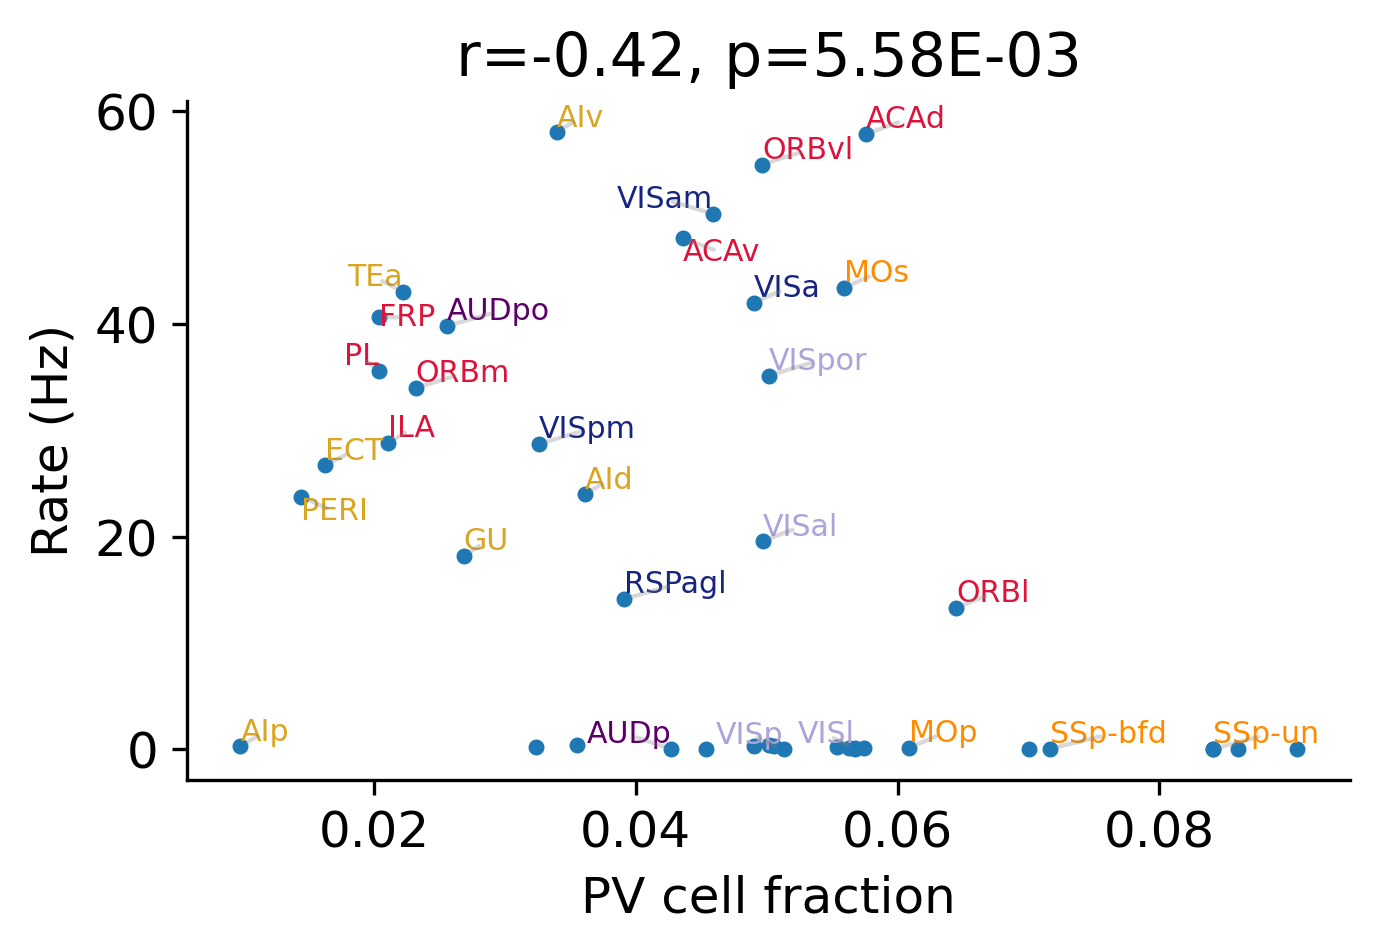

In [35]:
# make plot of raw pv vs firing rate
noLabelAreasPV = ['SSp-ll','SSp-ul','SSp-n','SSp-m','SSp-tr','VISli','VISpl','VISrl','RSPd','AUDv','SSs','AUDd','RSPv','VISC']
plotFRvsrawPVnotebook(model, rawPV_df, True, True, noLabelAreasPV, None, 8, (5,3), 12, True, 'makeFigures/FRvsrawPVnotebook.svg')

In [36]:
def generatePVHierDf(model, hierarchy_df, rawPV_df):
    c1, c2, c3, c4 = [], [], [], []
    for index, row in model.persistentact_df.iterrows():
        if row['Acronym'] in list(hierarchy_df.index):
            c1.append(row['Acronym'])
            # c2.append(row['PVdensity'])
            c2.append(rawPV_df.loc[row['Acronym']]['raw PV relative density'])
            c3.append(hierarchy_df.loc[row['Acronym']]['hierarchy index'])
            c4.append(row['persistentact'])
    df = pd.DataFrame()
    df['Acronym'] = c1
    df['PVdensity'] = c2
    df['hierarchy'] = c3
    df['persistentact'] = c4
    return df

In [37]:
def plotFRvsHiernotebook(model, PVHierDf, annotation_adjust, showLabel, noLabelAreas, yRange, dotSize, figureSize, fontSize, saveFig, fileName):
    
    div = model.parameters['div']
    div_name_list = model.parameters['div_name_list']
    div_color_list = model.parameters['div_color_list']

    fig = plt.figure(figsize=figureSize, dpi=300, facecolor='w', edgecolor='k')
    plt.rcParams.update({'font.size': fontSize})
    # plot FR vs hierarchy
    plt.scatter(PVHierDf['hierarchy'], PVHierDf['persistentact'],
               s=dotSize)
    ax = plt.gca()
    if yRange:
        plt.ylim(yRange) # leave enough space for annotation.
    # add annotation text
    if showLabel:
        texts = []
        xPos = []
        yPos = []
        for i in range(len(PVHierDf)):
            acr = PVHierDf['Acronym'][i]
            if acr in model.area_list:
                for div_name, div_color in zip(div_name_list, div_color_list):
                    if acr in div[div_name] and acr not in noLabelAreas:
                        xPos += PVHierDf['hierarchy'][i]
                        yPos += PVHierDf['persistentact'][i]
                        texts += [ax.text(PVHierDf['hierarchy'][i],
                                          PVHierDf['persistentact'][i], acr,
                                          color=div_color, fontsize=fontSize*0.6)]
                        
        # # use adjust library to adjust the position of annotations.
        if annotation_adjust:
            adjust_text(texts, xPos, yPos,
                        ax=ax, precision=0.001,
                        arrowprops=dict(arrowstyle='-', color='gray', alpha=.3))

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # plt.setp(ax.spines.values(), linewidth=3)
    # ax.xaxis.set_tick_params(width=7)
    # ax.yaxis.set_tick_params(width=7)

    plt.xlabel('Hierarchy')
    plt.ylabel('Rate (Hz)')
    # plt.ylim([-1,8])

    corr, pvalue = sp.stats.pearsonr(PVHierDf['hierarchy'],
                                     PVHierDf['persistentact'])
    plt.title('r=' + str(round(corr, 2)) + ', p=' + f"{pvalue:.2E}")
    print(f"{pvalue:.2E}")

    # save figure
    if saveFig:
        plt.savefig('figure/' + fileName, dpi=300, bbox_inches='tight',transparent=True)
    # plt.savefig('figure/neurondensity_grad.png',dpi=80,bbox_inches='tight')

2.21E-17


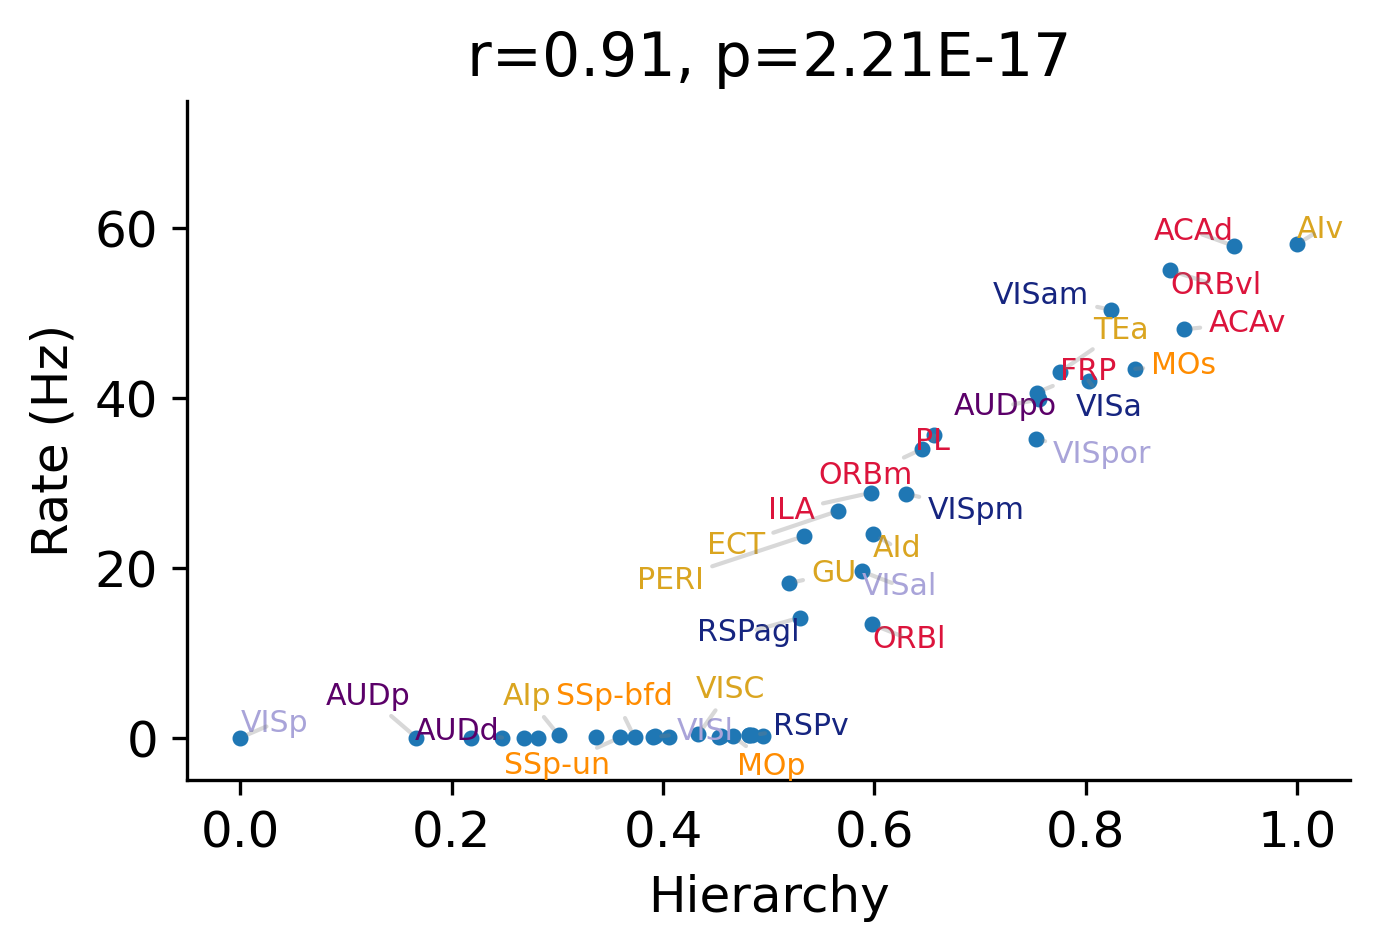

In [38]:
PVHierDf = generatePVHierDf(model, hierarchy_df, rawPV_df)
plotFRvsHiernotebook(model, PVHierDf, True, True, noLabelAreas,[-5,75], 8, (5,3), 12, True, 'makeFigures/FRvsHiernotebook.svg')

In [39]:
def plotPVvsHiernotebook(model, PVHierDf, annotation_adjust, showLabel, dotSize, figureSize, fontSize, saveFig, fileName):
    
    div = model.parameters['div']
    div_name_list = model.parameters['div_name_list']
    div_color_list = model.parameters['div_color_list']

    fig = plt.figure(figsize=figureSize, dpi=300, facecolor='w', edgecolor='k')
    plt.rcParams.update({'font.size': fontSize})
    # plot FR vs hierarchy
    plt.scatter(PVHierDf['hierarchy'], PVHierDf['PVdensity'],
               s=dotSize)
    ax = plt.gca()
    # plt.ylim(-6.5,65) # leave enough space for annotation.
    # add annotation text
    if showLabel:
        texts = []
        for i in range(len(PVHierDf)):
            acr = PVHierDf['Acronym'][i]
            if acr in model.area_list:
                for div_name, div_color in zip(div_name_list, div_color_list):
                    if acr in div[div_name]:
                        texts += [ax.text(PVHierDf['hierarchy'][i],
                                          PVHierDf['PVdensity'][i], acr,
                                          color=div_color, fontsize=fontSize*0.6)]

        # # use adjust library to adjust the position of annotations.
        if annotation_adjust:
            adjust_text(texts, PVHierDf['hierarchy'], PVHierDf['PVdensity'],
                        ax=ax, precision=0.001,
                        arrowprops=dict(arrowstyle='-', color='gray', alpha=.3))

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # plt.setp(ax.spines.values(), linewidth=3)
    # ax.xaxis.set_tick_params(width=7)
    # ax.yaxis.set_tick_params(width=7)

    plt.xlabel('Hierarchy')
    plt.ylabel('PV cell fraction')
    # plt.ylim([-1,8])

    corr, pvalue = sp.stats.pearsonr(PVHierDf['hierarchy'],
                                     PVHierDf['PVdensity'])
    plt.title('r=' + str(round(corr, 2)) + ', p=' + f"{pvalue:.2E}")
    print(f"{pvalue:.2E}")

    # save figure
    if saveFig:
        plt.savefig('figure/' + fileName, dpi=300, bbox_inches='tight',transparent=True)
    # plt.savefig('figure/neurondensity_grad.png',dpi=80,bbox_inches='tight')

WARNING    /Users/Allen/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)
 [py.warnings]


2.57E-02


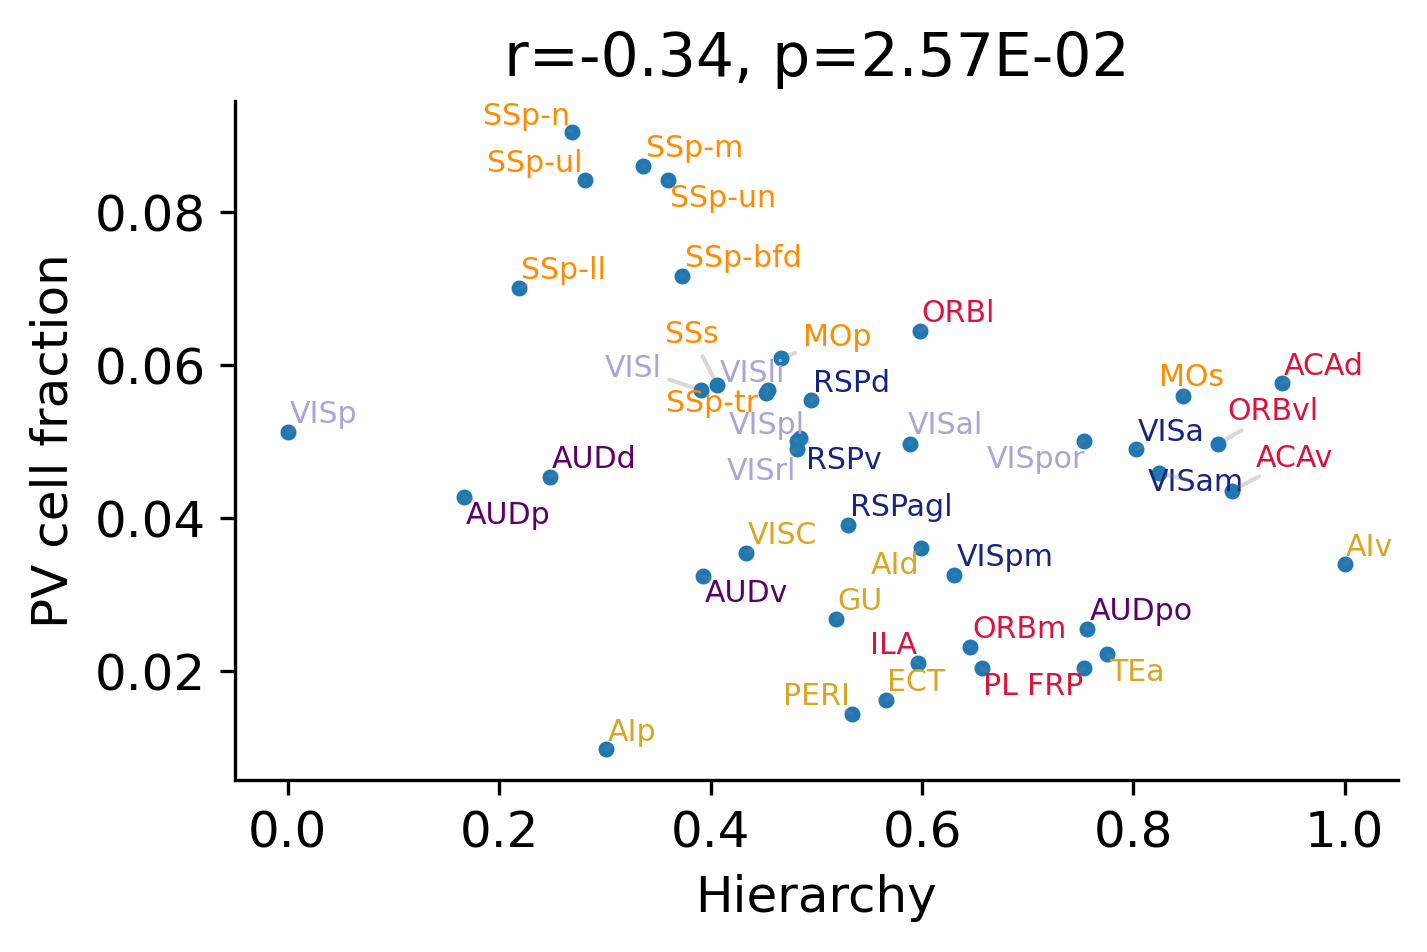

In [40]:
plotPVvsHiernotebook(model, PVHierDf, True, True, 8, (5,3), 12, True, 'makeFigures/PVvsHiernotebook.svg')

5.58E-03


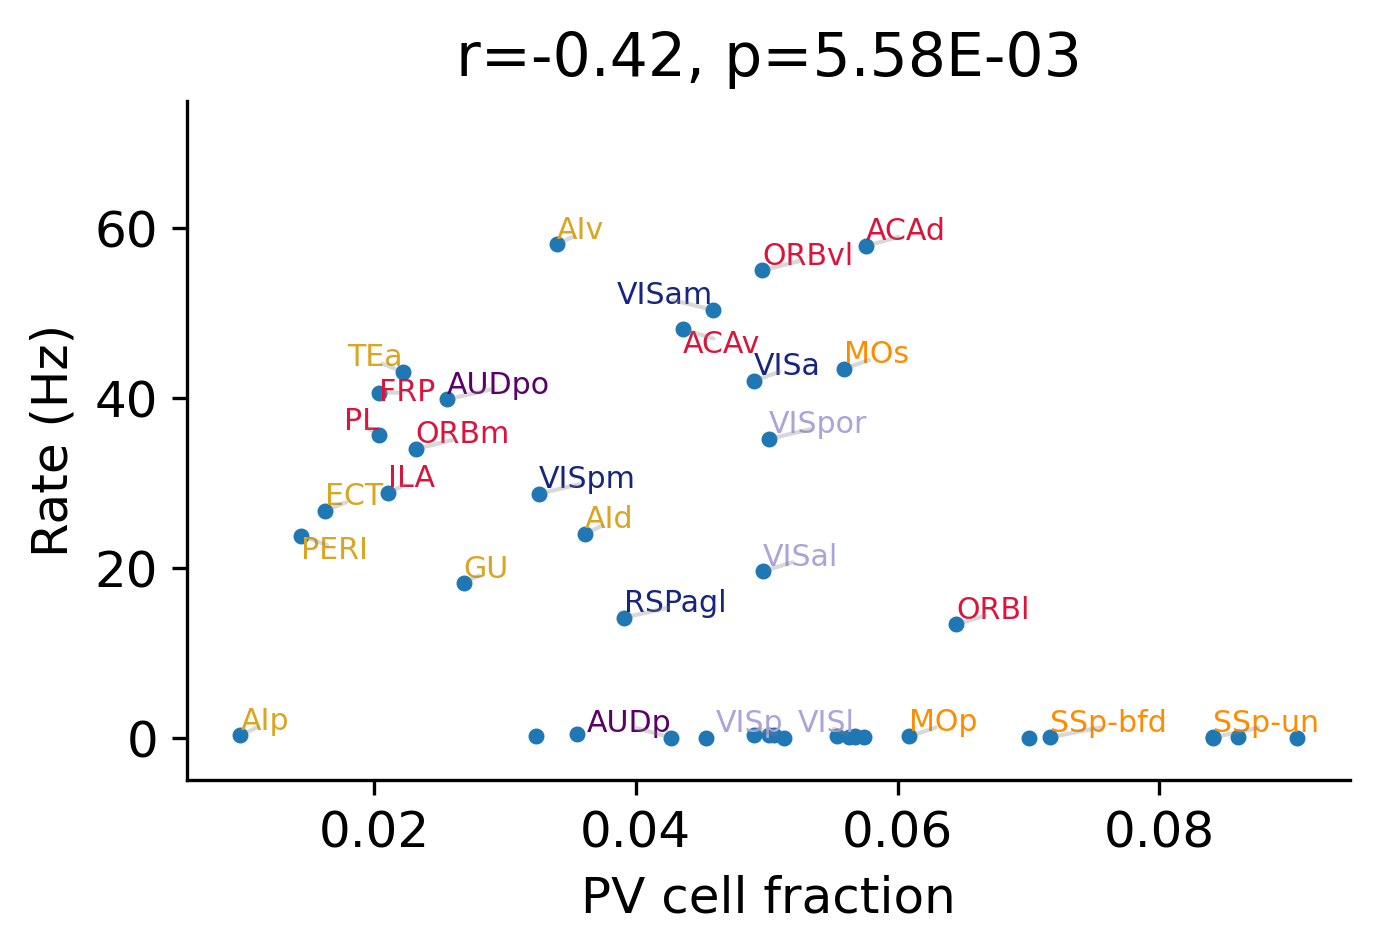

In [41]:
# for making figures of noPVnoCIBsim. 
# make plot of raw pv vs firing rate
noLabelAreasPV = ['SSp-ll','SSp-ul','SSp-n','SSp-m','SSp-tr','VISli','VISpl','VISrl','RSPd','AUDv','SSs','AUDd','RSPv','VISC']
plotFRvsrawPVnotebook(model, rawPV_df, True, True, noLabelAreasPV, [-5,75], 8, (5,3), 12, True, 'noPVnoCIBsim/FRvsrawPVnotebook.pdf')

9.79E-09


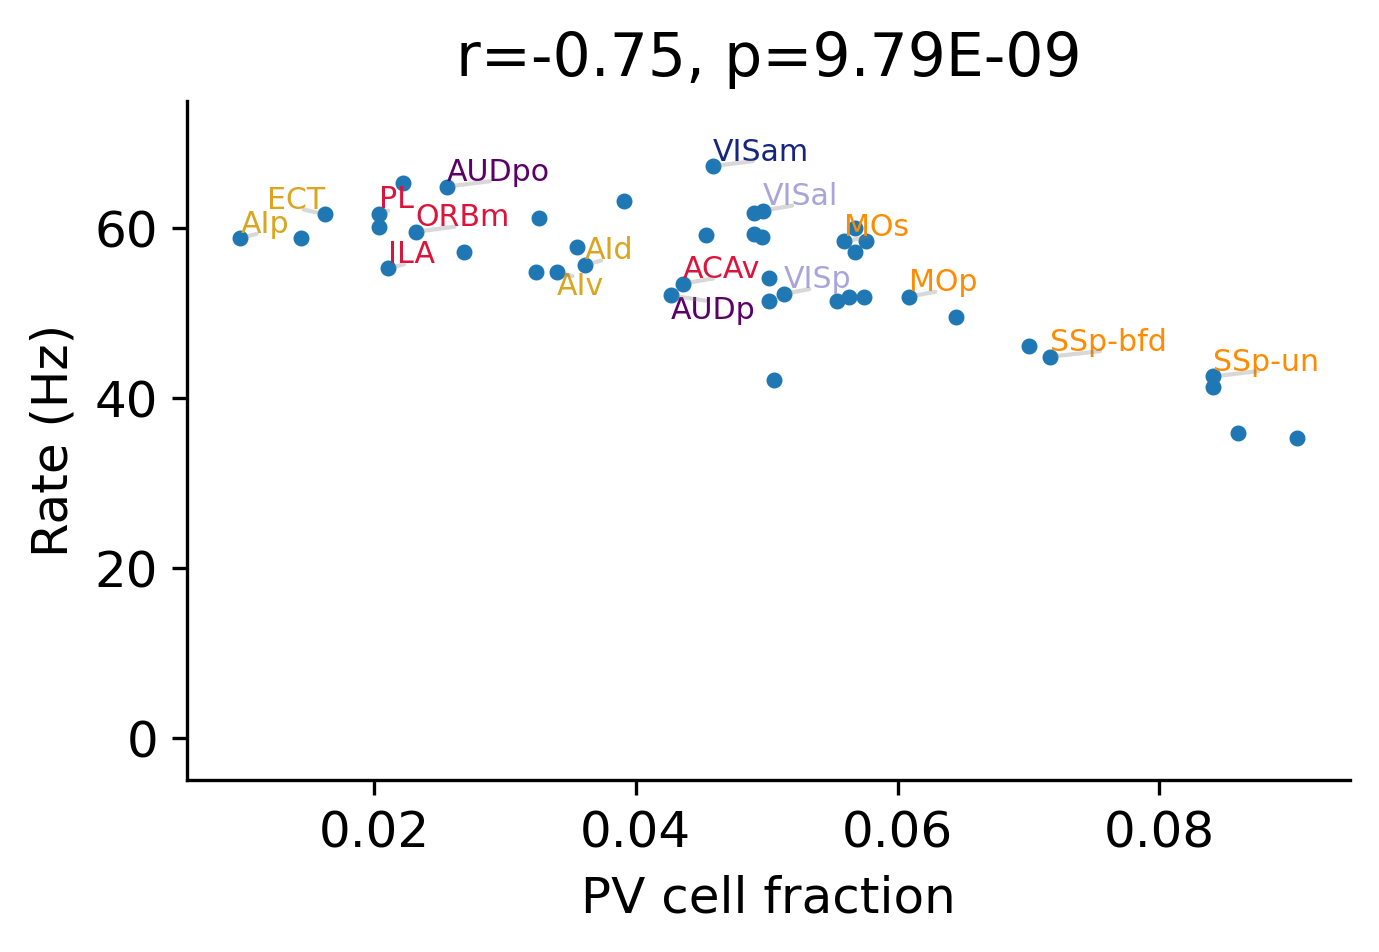

In [42]:
# make plot of raw pv vs firing rate for no CIB model
noLabelAreasPV = ['SSp-ll','SSp-ul','SSp-n','SSp-m','SSp-tr','VISli','VISpl','VISrl','RSPd','AUDv','SSs','AUDd','RSPv','VISC','VISpor',
                  'PERI','TEa','FRP','GU','VISpm','RSPagl','VISa','ORBvl','ACAd','VISl','ORBl']
plotFRvsrawPVnotebook(modelAveragePref, rawPV_df, True, True, noLabelAreasPV, [-5, 75], 8, (5,3), 12, True, 'noPVnoCIBsim/FRvsrawPVnotebook_avePref.pdf')

5.67E-13


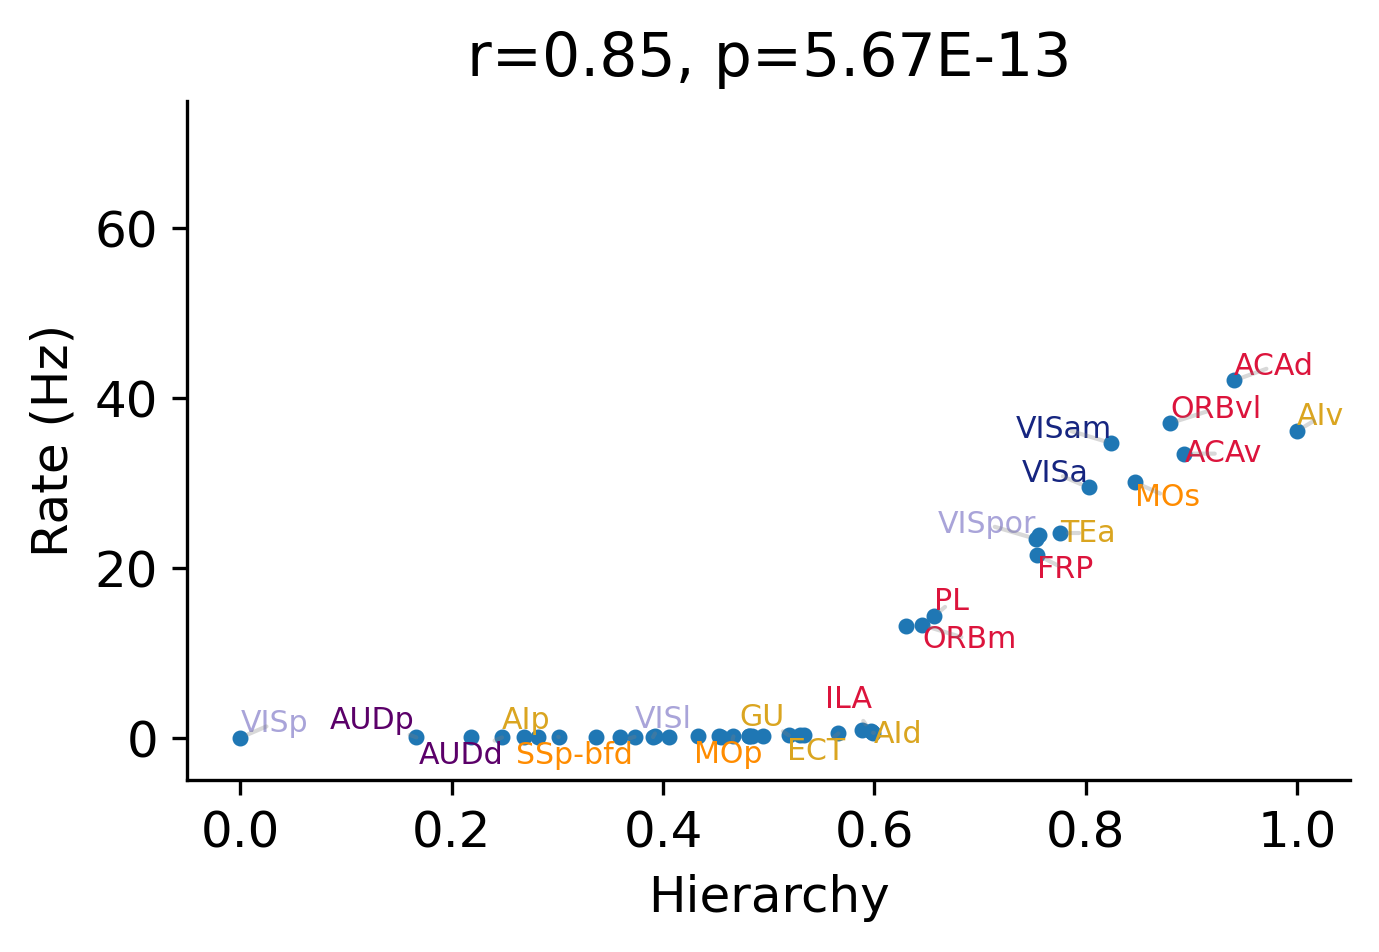

In [43]:
# make plot of hierarchy vs firing rate for constant PV model
# noLabelAreas =  ['SSp-ll','SSp-ul','SSp-n','SSp-m','SSp-tr','VISli','VISpl','VISrl','RSPd','AUDv','SSs']
noLabelAreas =  ['SSp-ll','SSp-ul','SSp-n','SSp-m','SSp-tr','VISli','VISpl','VISrl','RSPd','AUDv','SSs',
                 'SSp-un','VISC','RSPagl','PERI','ORBl','RSPv','AUDpo','VISal','VISpm']
PVHierDf = generatePVHierDf(modelAveragePV, hierarchy_df, rawPV_df)
plotFRvsHiernotebook(modelAveragePV, PVHierDf, True, True, noLabelAreas,[-5,75], 8, (5,3), 12, True, 'noPVnoCIBsim/FRvsHiernotebook_avePV.pdf')

1.48E-07


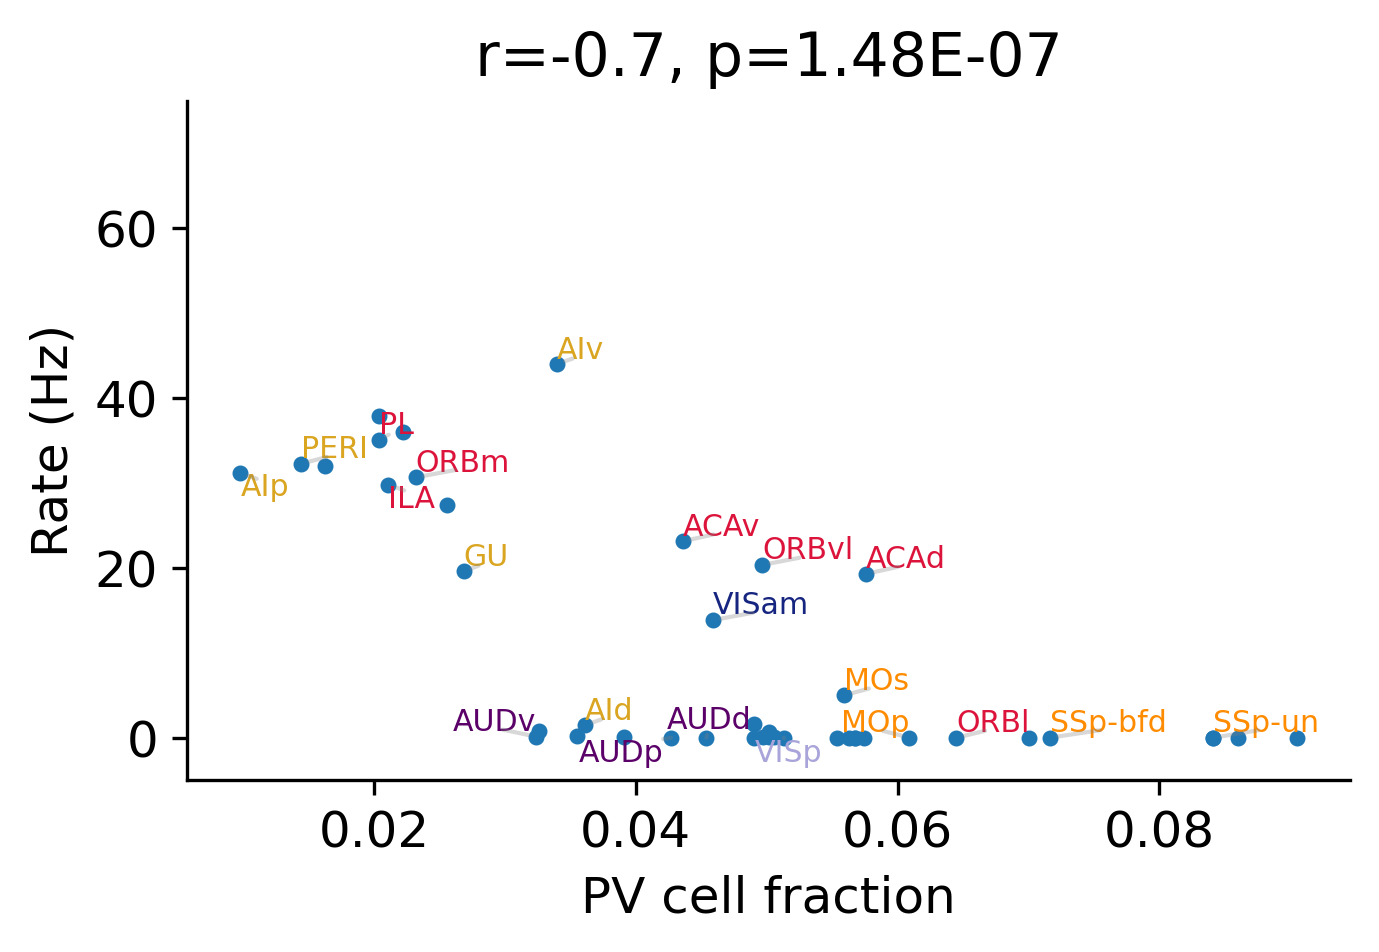

In [44]:
# make plot of raw pv vs firing rate for model in the alternative regime.
# noLabelAreasPV = ['SSp-ll','SSp-ul','SSp-n','SSp-m','SSp-tr','VISli','VISpl','VISrl','RSPd','AUDv','SSs','AUDd','RSPv','VISC', 'ACAv','VISam','VISa','ORBvl','VISpor','AUDp', 'MOs']
noLabelAreasPV = ['SSp-ll','SSp-ul','SSp-n','SSp-m','SSp-tr','VISli','VISpl','VISrl','RSPd',
                  'VISl','VISal','VISpor','VISa','VISC','VISpm','RSPagl','RSPv','SSs','TEa','AUDpo',
                  'FRP','ECT']
plotFRvsrawPVnotebook(modelAlternative, rawPV_df, True, True, noLabelAreasPV, [-5, 75], 8, (5,3), 12, True, 'noPVnoCIBsim/FRvsrawPVnotebook_alt.pdf')

1.53E-12


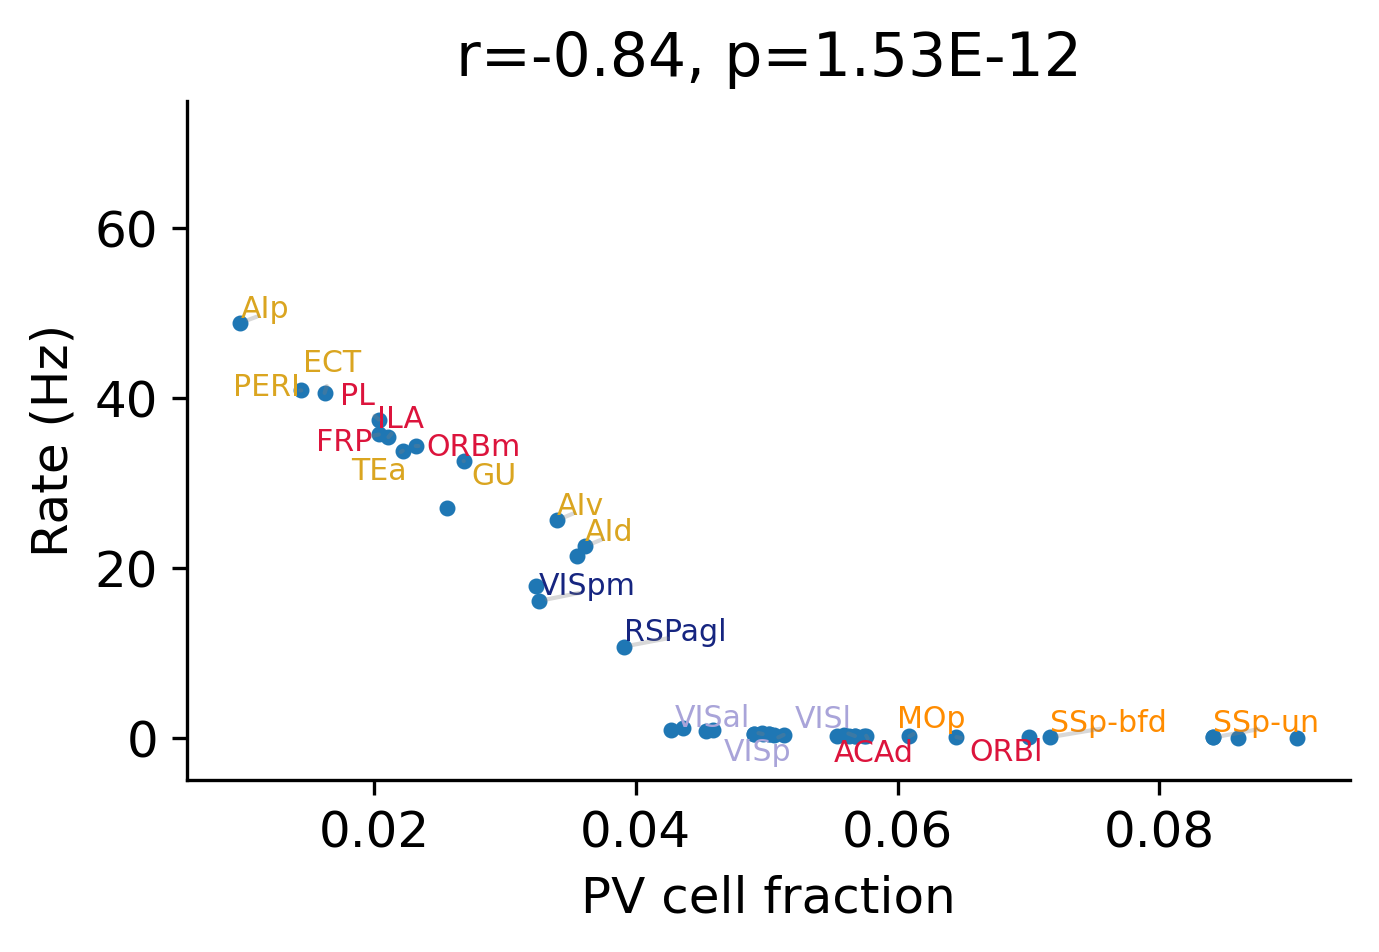

In [45]:
# make plot of raw pv vs firing rate for no CIB model in the alternative regime.
noLabelAreasPV = ['SSp-ll','SSp-ul','SSp-n','SSp-m','SSp-tr','VISli','VISpl','VISrl','RSPd','AUDv','SSs','AUDd','RSPv','VISC', 'ACAv','VISam','VISa','ORBvl','VISpor','AUDp', 'MOs',
                  'AUDpo']
plotFRvsrawPVnotebook(modelAlternativeAveragePref, rawPV_df, True, True, noLabelAreasPV, [-5, 75], 8, (5,3), 12, True, 'noPVnoCIBsim/FRvsrawPVnotebook_avePref_alt.pdf')

8.73E-23


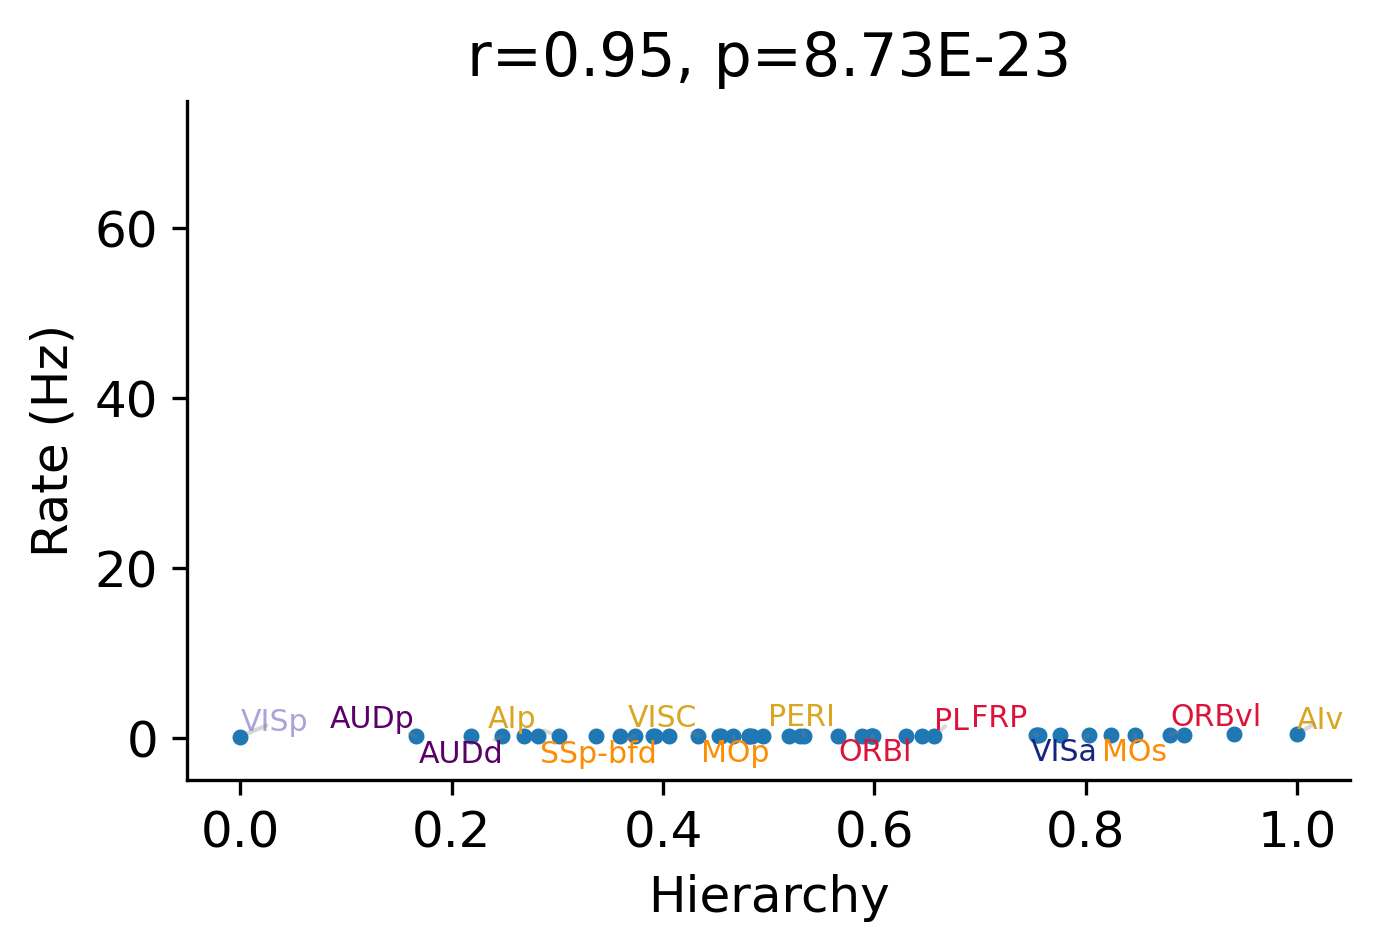

In [46]:
# make plot of hierarchy vs firing rate for constant PV model in the alternative regime.
noLabelAreas =  ['SSp-ll','SSp-ul','SSp-n','SSp-m','SSp-tr','VISli','VISpl','VISrl','RSPd','AUDv','SSs',
                 'SSp-un','VISl','RSPv','RSPagl','GU','ECT','AId','VISpm',
                 'VISpor','AUDpo','VISam','ACAv','ACAd','VISal','ORBm','ILA','TEa']
PVHierDf = generatePVHierDf(modelAlternativeAveragePV, hierarchy_df, rawPV_df)
plotFRvsHiernotebook(modelAlternativeAveragePV, PVHierDf, True, True, noLabelAreas,[-5,75], 8, (5,3), 12, True, 'noPVnoCIBsim/FRvsHiernotebook_avePV_alt.pdf')

6.63E-11


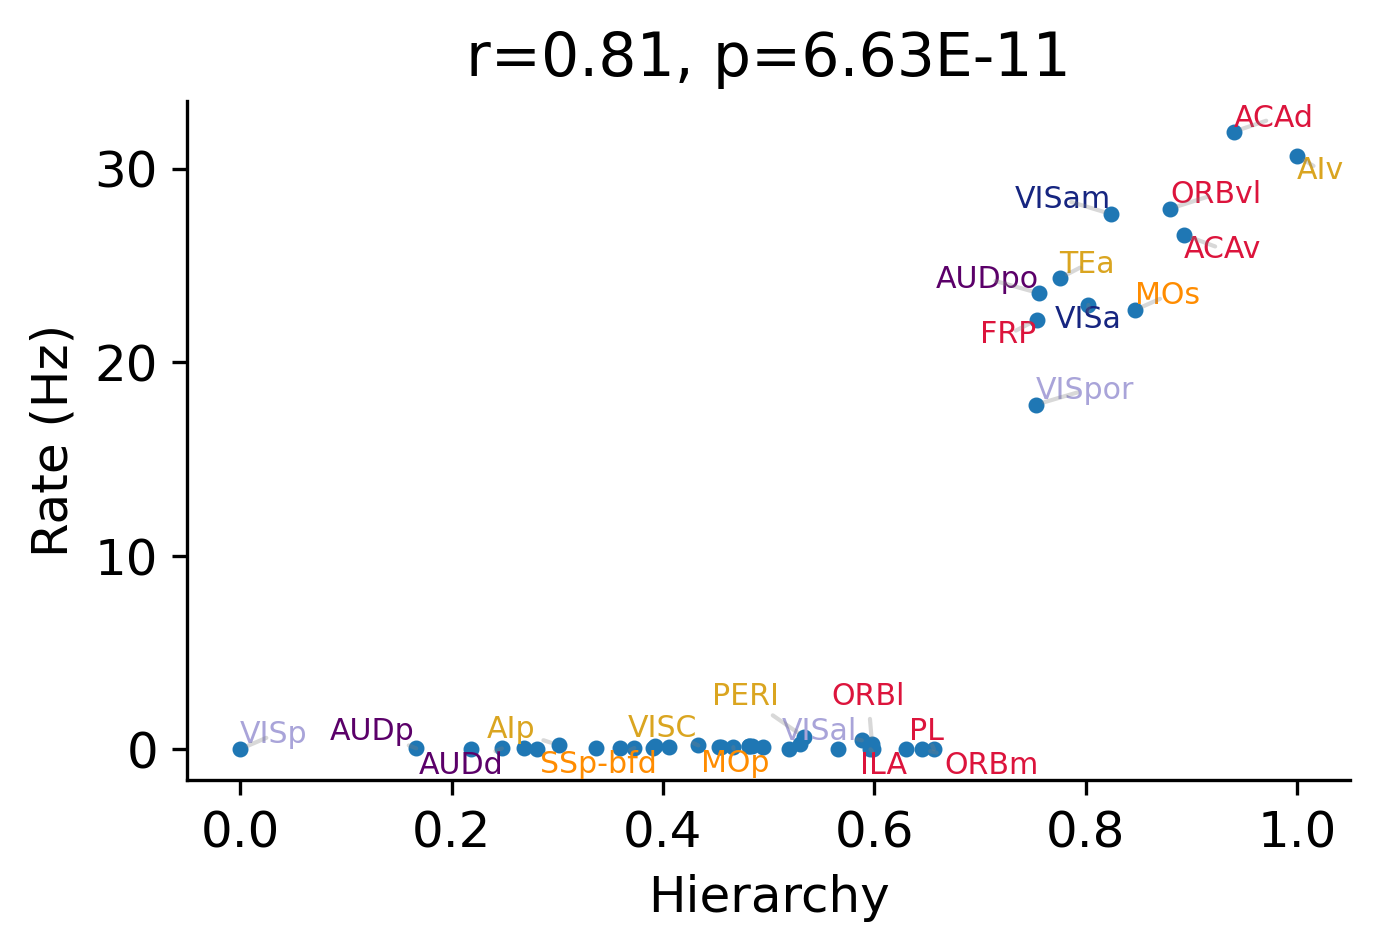

In [47]:
# plot the firing rate plot for all core inhibition
noLabelAreas =  ['SSp-ll','SSp-ul','SSp-n','SSp-m','SSp-tr','VISli','VISpl','VISrl','RSPd','AUDv','SSs',
                 'SSp-un','VISl','RSPv','RSPagl','GU','ECT','AId','VISpm']
PVHierDf = generatePVHierDf(modelAllcore, hierarchy_df, rawPV_df)
plotFRvsHiernotebook(modelAllcore, PVHierDf, True, True, noLabelAreas,None, 8, (5,3), 12, True, 'makeFigures/FRvsHiernotebook_allcore.pdf')


In [48]:
 # early firing ralated code need to be included into the main sim code. 

In [49]:
def generateColorMap(value, cmap, area_list):
    colorlist = []
    allstring = '{' 
    maxval = np.max(value)
    for i in range(len(area_list)):
        newstr = '"' + area_list[i] + '1":{},'.format(i + 1)
        allstring += newstr #allstring stores the names of all cortical areas 
        cval = value[i]
        norm = mpl.colors.Normalize(vmin=0, vmax=1)
        mycolor = list(cmap(norm(cval / maxval))[0:3])
        colorCode = [int(255*mycolor[0]), int(255*mycolor[1]), int(255*mycolor[2])]
        colorlist.append(colorCode)
    allstring = allstring[:-1] + '}'
    return allstring, colorlist

In [50]:
# get early firing  # need to be included into the main sim code
earlyPAlist = []
earlyPAstarttime = 2.5 * brian2.second
earlyPAendtime = 3 * brian2.second
for i in range(len(area_list)):
    earlyPA = np.mean(model.R[np.arange(int(earlyPAstarttime / model.dt), int(earlyPAendtime / model.dt), 1), i , 0]) / brian2.Hz
    earlyPAlist.append(earlyPA)
print(earlyPAlist)

earlyCurrlist = []
for i in range(len(area_list)):
    earlyCurr = np.mean(model.S_NMDA[np.arange(int(earlyPAstarttime / model.dt), int(earlyPAendtime / model.dt), 1), i , 0])
    earlyCurrlist.append(earlyCurr)
print(earlyCurrlist)

[0.35430619200558794, 0.015187015813405534, 0.006707045521934573, 0.016378036366415025, 0.019868008630656655, 0.011102938825964262, 0.2791898529124562, 0.03391460223065978, 0.026200016697442735, 0.041043916683067255, 0.06945223095901307, 0.27938760651952455, 0.10900295785398204, 0.39096911027087705, 0.16106107421583574, 0.23549496922771262, 0.15824978713020948, 0.7389242253526151, 3.5376021984361974, 0.3516664298052006, 0.36928383296646383, 12.452590028841557, 16.742380101921263, 24.298789328455143, 27.312167904748602, 22.0828695097728, 28.9416882211966, 7.972332739337957, 23.312111571942026, 30.306888640334467, 34.27249248759113, 35.60764546101597, 37.09401714010139, 39.89207395888852, 41.30842126167131, 44.03294515981745, 43.387332023236596, 52.19744194694197, 43.49523872743089, 55.268483752095605, 48.800040834463516, 58.56976784470322, 57.45727322399462]
[0.1055033374521512, 0.0012149012087551085, 0.0005407102936246684, 0.0013408791793595842, 0.001585785776647652, 0.0008889242657299

In [51]:
mapStr, FRcolorlist = generateColorMap(model.persistentact_df['persistentact'], plt.cm.viridis, area_list)
_, PVcolorlist = generateColorMap(model.persistentact_df['PVdensity'], plt.cm.copper, area_list)
_, Hiercolorlist = generateColorMap(model.persistentact_df['Hierarchy'], plt.cm.viridis, area_list)
_, earlyPAcolorlist = generateColorMap(earlyPAlist, plt.cm.viridis, area_list)
_, earlyCurrcolorlist = generateColorMap(earlyCurrlist, plt.cm.viridis, area_list)

print(mapStr)
print(FRcolorlist)
print(PVcolorlist)
print(Hiercolorlist)
# print(earlyPAcolorlist)
# print(earlyCurrcolorlist)
# the background color is white [255,255,255] , website: https://scalablebrainatlas.incf.org/services/view3d_l2v_bkp.php?template=ABA_v3
# if not working, use this one. 
# https://scalablebrainatlas.incf.org/services/view3d_l2v.php?template=ABA_v3&space=ABA_v3&mesh=wholebrain&deform=fiducial&l2v=&clim=%5Bnull%2Cnull%5D&bg=%5B0%2C0%2C0%5D&width=800&height=800&cam=L&overlay=labels&format=xhtml

{"VISp1":1,"AUDp1":2,"SSp-ll1":3,"AUDd1":4,"SSp-n1":5,"SSp-ul1":6,"AIp1":7,"SSp-m1":8,"SSp-un1":9,"SSp-bfd1":10,"VISl1":11,"AUDv1":12,"SSs1":13,"VISC1":14,"SSp-tr1":15,"VISli1":16,"MOp1":17,"VISrl1":18,"VISpl1":19,"RSPv1":20,"RSPd1":21,"GU1":22,"RSPagl1":23,"PERI1":24,"ECT1":25,"VISal1":26,"ILA1":27,"ORBl1":28,"AId1":29,"VISpm1":30,"ORBm1":31,"PL1":32,"VISpor1":33,"FRP1":34,"AUDpo1":35,"TEa1":36,"VISa1":37,"VISam1":38,"MOs1":39,"ORBvl1":40,"ACAv1":41,"ACAd1":42,"AIv1":43}
[[68, 1, 84], [68, 1, 84], [68, 1, 84], [68, 1, 84], [68, 1, 84], [68, 1, 84], [68, 2, 85], [68, 1, 84], [68, 1, 84], [68, 1, 84], [68, 1, 84], [68, 2, 85], [68, 1, 84], [68, 2, 85], [68, 1, 84], [68, 1, 84], [68, 1, 84], [68, 2, 85], [68, 2, 85], [68, 2, 85], [68, 2, 85], [50, 98, 141], [59, 80, 138], [40, 122, 142], [36, 134, 141], [48, 104, 141], [33, 142, 140], [61, 75, 137], [40, 122, 142], [33, 142, 140], [32, 164, 133], [36, 170, 130], [35, 168, 131], [68, 190, 112], [61, 187, 116], [87, 198, 101], [79, 195, 10

In [52]:
# generate the colorbar for activity map
def generateColorbar(value, cmap, fixmax, title, figureSize, fontSize, saveFig, fileName):
    fig, ax = plt.subplots(figsize=figureSize, dpi=300, facecolor='w', edgecolor='k')
    plt.rcParams.update({'font.size': fontSize})
    fig.subplots_adjust(bottom=0.5)
    if fixmax:
        norm = mpl.colors.Normalize(vmin=0, vmax=fixmax)
    else:
        norm = mpl.colors.Normalize(vmin=0, vmax=np.max(value))

    # plot the colorbar with maximum firing labeling
    cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                    norm=norm,
                                    orientation='vertical')
    cb1.set_label(title)
    #     cb1.ax.tick_params(labelsize=20)
    # fig.show()
    if saveFig:
        plt.savefig('figure/' + fileName, dpi=300, bbox_inches='tight', transparent=True)

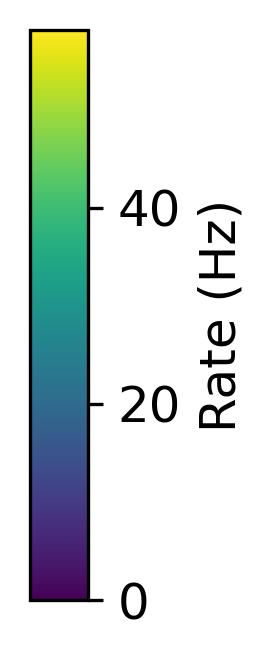

In [53]:
generateColorbar(model.persistentact_df['persistentact'], mpl.cm.viridis, None,
                 'Rate (Hz)', (0.25, 5), 12, True, 'makeFigures/FRcolorbar.svg')

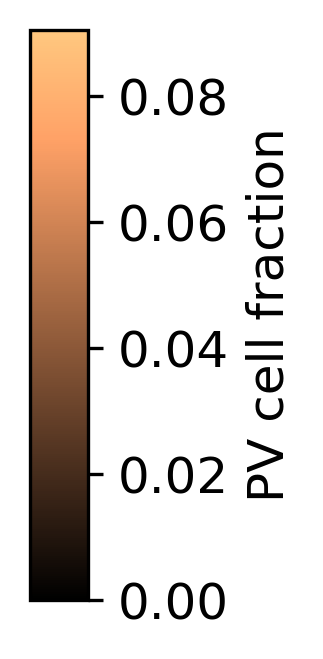

In [54]:
generateColorbar(PVHierDf['PVdensity'], mpl.cm.copper, None,
                 'PV cell fraction', (0.25, 5), 12, True, 'makeFigures/PVcolorbar.svg')

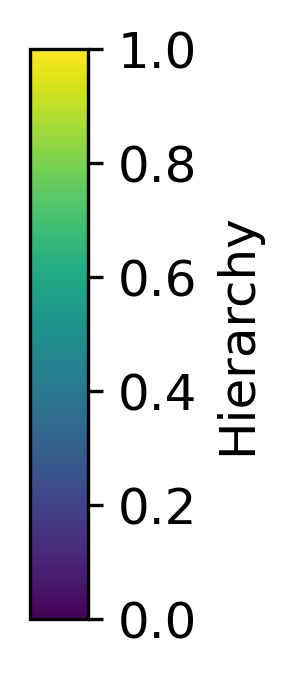

In [55]:
generateColorbar(model.persistentact_df['Hierarchy'], mpl.cm.viridis, None,
                 'Hierarchy', (0.25, 5), 12, True, 'makeFigures/Hierarchycolorbar.svg')

In [56]:
# generateColorbar(earlyPAlist, mpl.cm.viridis, None, 
#                  'Rate (Hz)', (0.25, 5), 12, True, 'earlyPAcolorbar.pdf')

In [57]:
# generateColorbar(earlyCurrlist, mpl.cm.viridis, 1, 
#                  'Synaptic variable', (0.25, 5), 12, True, 'earlySynapticcolorbar.pdf')

In [59]:
# make plots for simulations with different sensory modularity. 

# load S1 model
with open('results/model_S1.pkl', 'rb') as f:
    model_S1 = pickle.load(f)
# load A1 model
with open('results/model_A1.pkl', 'rb') as f:
    model_A1 = pickle.load(f)

['SSp-bfd', 'ILA', 'ORBm', 'PL', 'VISa', 'MOs']
1.46E-15
8.31E-03


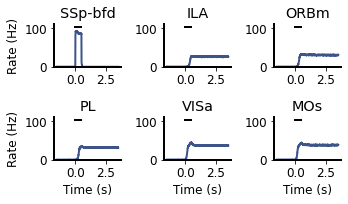

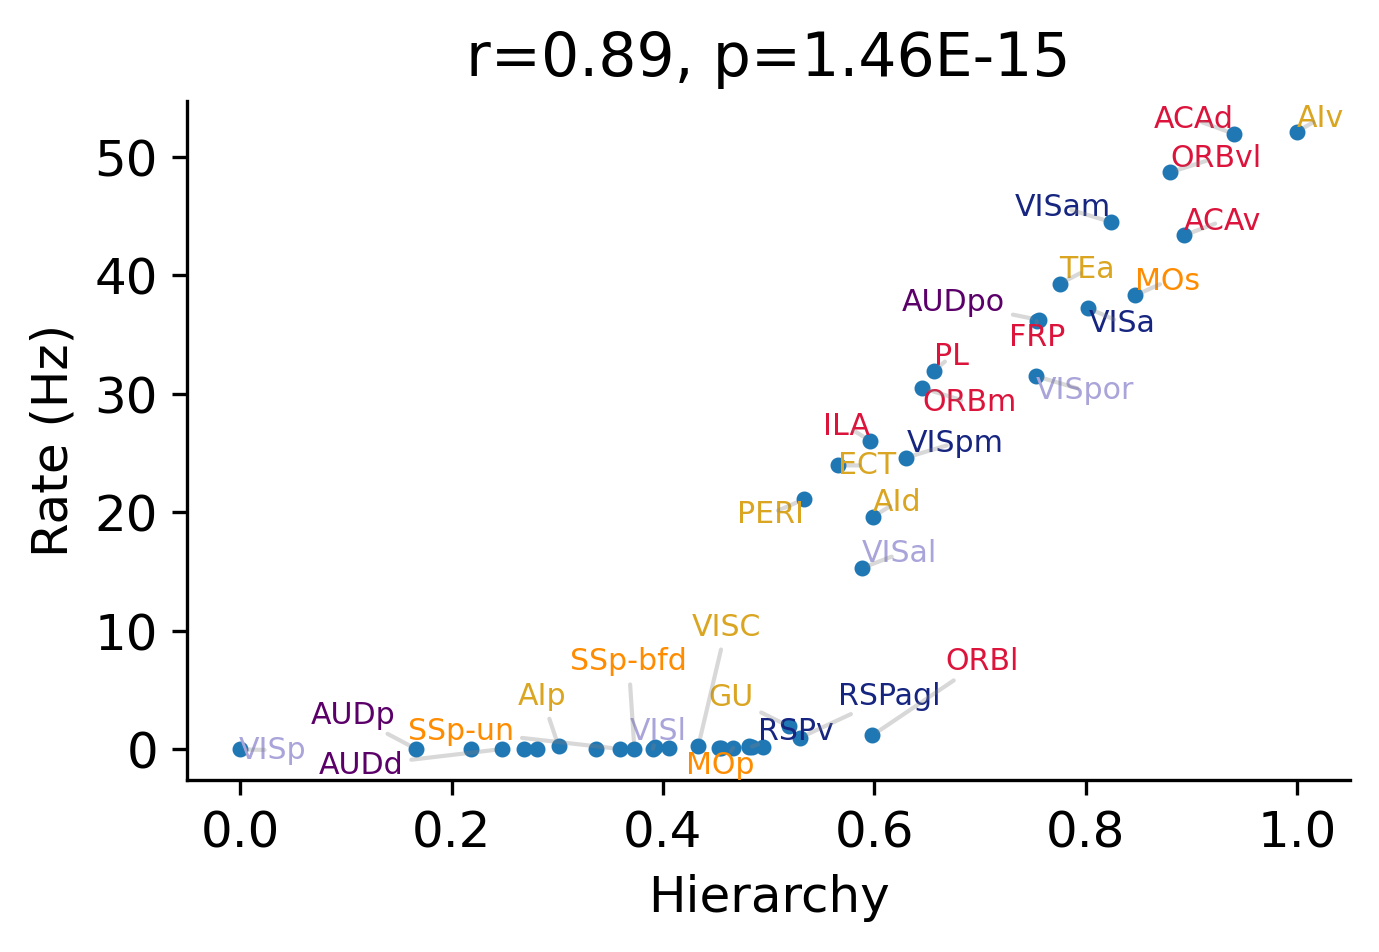

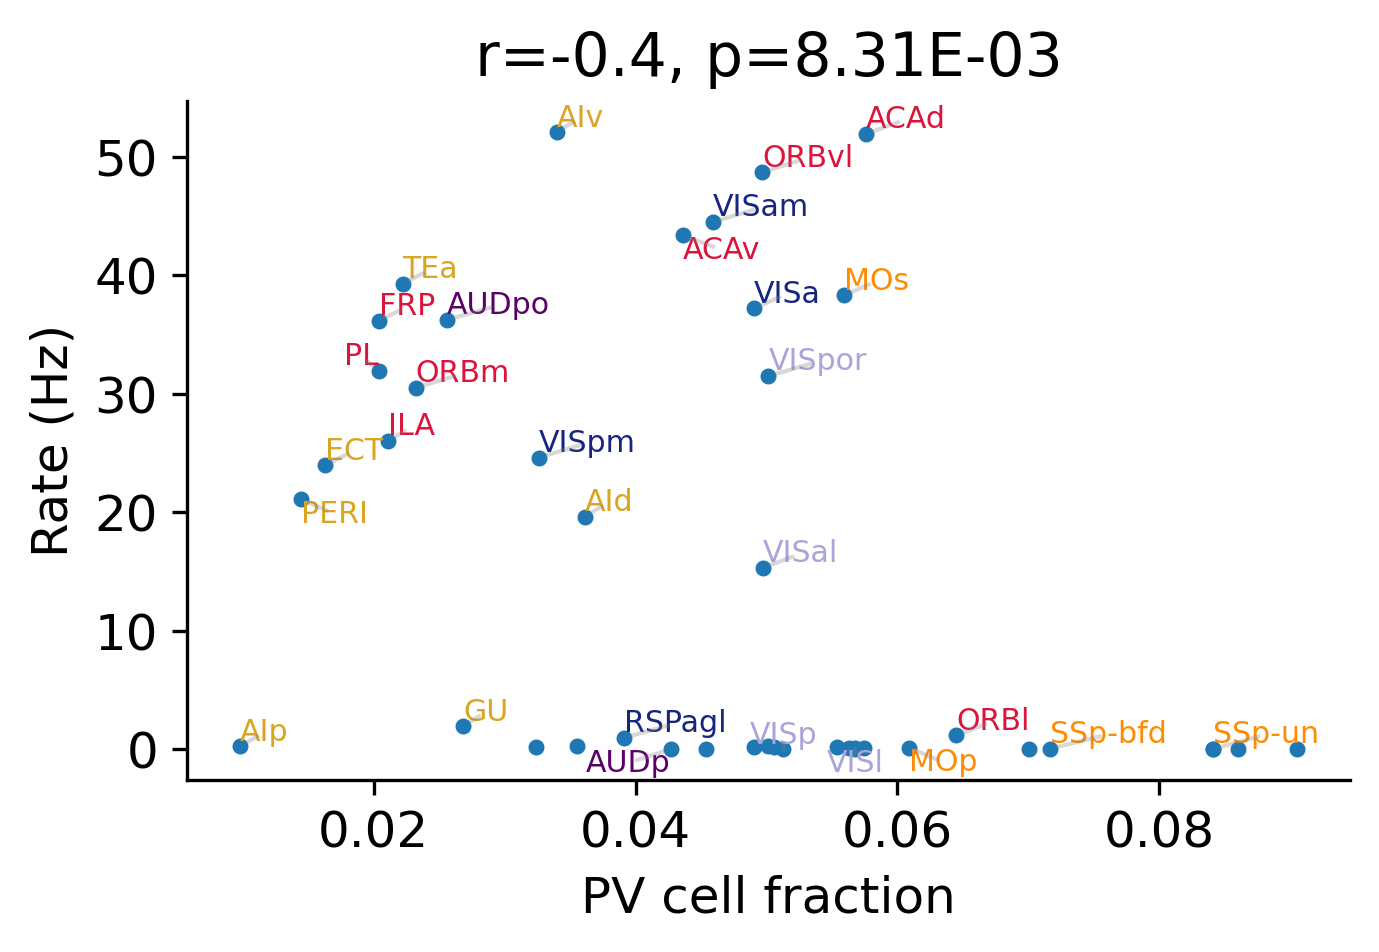

In [60]:
ROIlist_S1 = [9,26,30,31,36, 38]
# ROIlist_S1 = [9,21,26,30,31, 38]
print([area_list[i] for i in ROIlist_S1])
plotAreaList_S1 = [i+1 for i in ROIlist_S1]  # VISp stimulus
# plot firing rates for sample areas
plotDynamics(model_S1, plotAreaList_S1, 'FR', True, 2, (5,3), 12, True, 'makeFigures/dynamicsPlotModelS1.svg')
PVHierDfModelS1 = generatePVHierDf(model_S1, hierarchy_df, rawPV_df)
noLabelAreas = ['SSp-ll','SSp-ul','SSp-n','SSp-m','SSp-tr','VISli','VISpl','VISrl','RSPd','AUDv','SSs']
plotFRvsHiernotebook(model_S1, PVHierDfModelS1, True, True, noLabelAreas, None, 8, (5,3), 12, True, 'makeFigures/FRvsHiernotebookModelS1.svg')
# make plot of raw pv vs firing rate
noLabelAreasPV = ['SSp-ll','SSp-ul','SSp-n','SSp-m','SSp-tr','VISli','VISpl','VISrl','RSPd','AUDv','SSs','AUDd','RSPv','VISC']
plotFRvsrawPVnotebook(model_S1, rawPV_df, True, True, noLabelAreasPV, None, 8, (5,3), 12, True, 'makeFigures/FRvsrawPVnotebookS1.svg')

['AUDp', 'ILA', 'ORBm', 'PL', 'VISa', 'MOs']
1.46E-15
8.31E-03


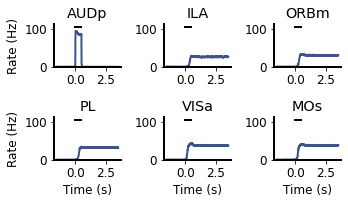

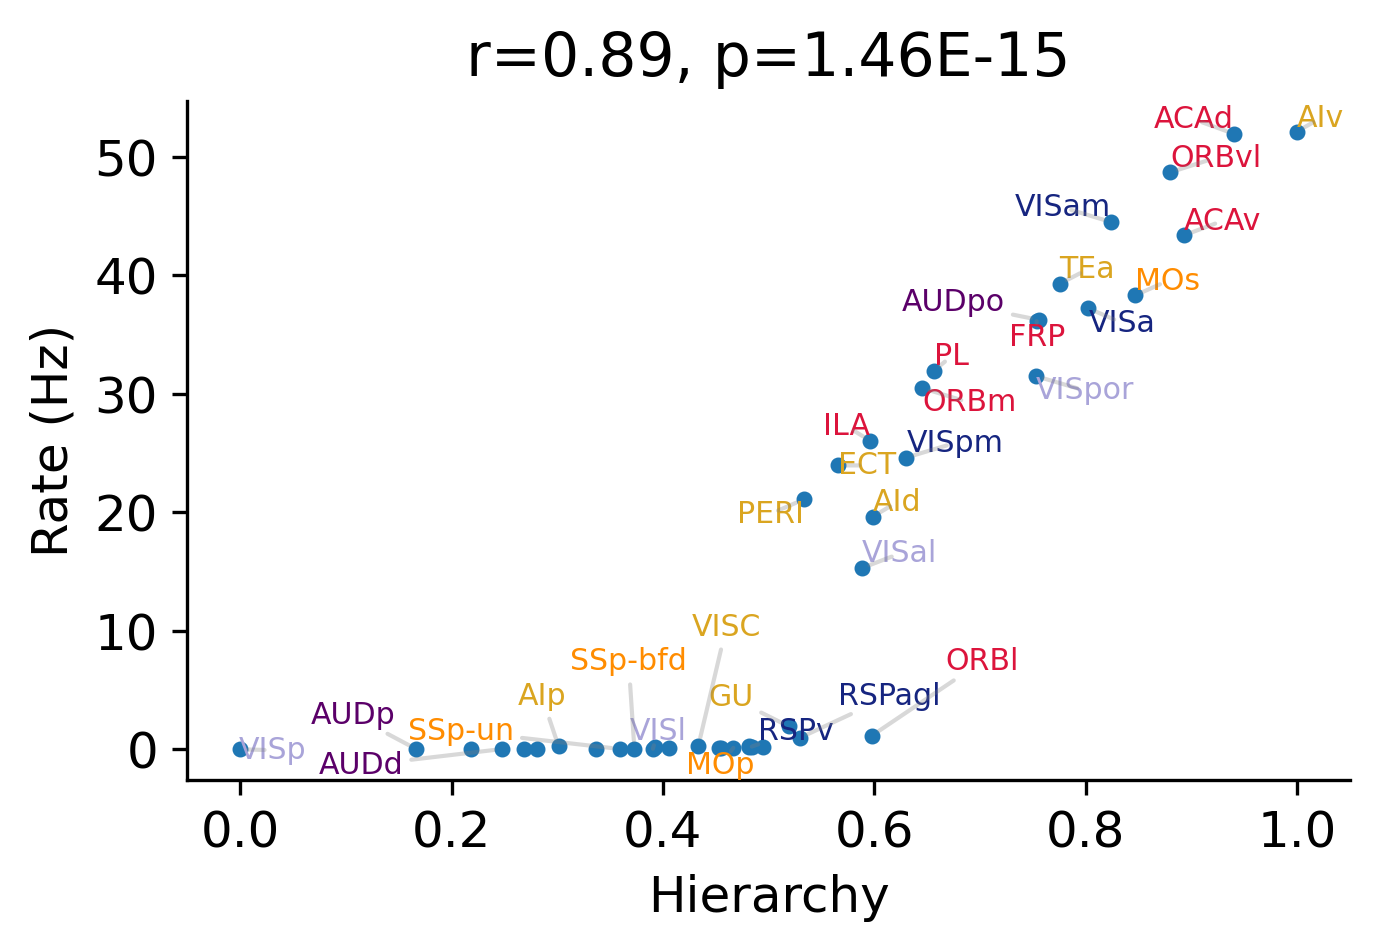

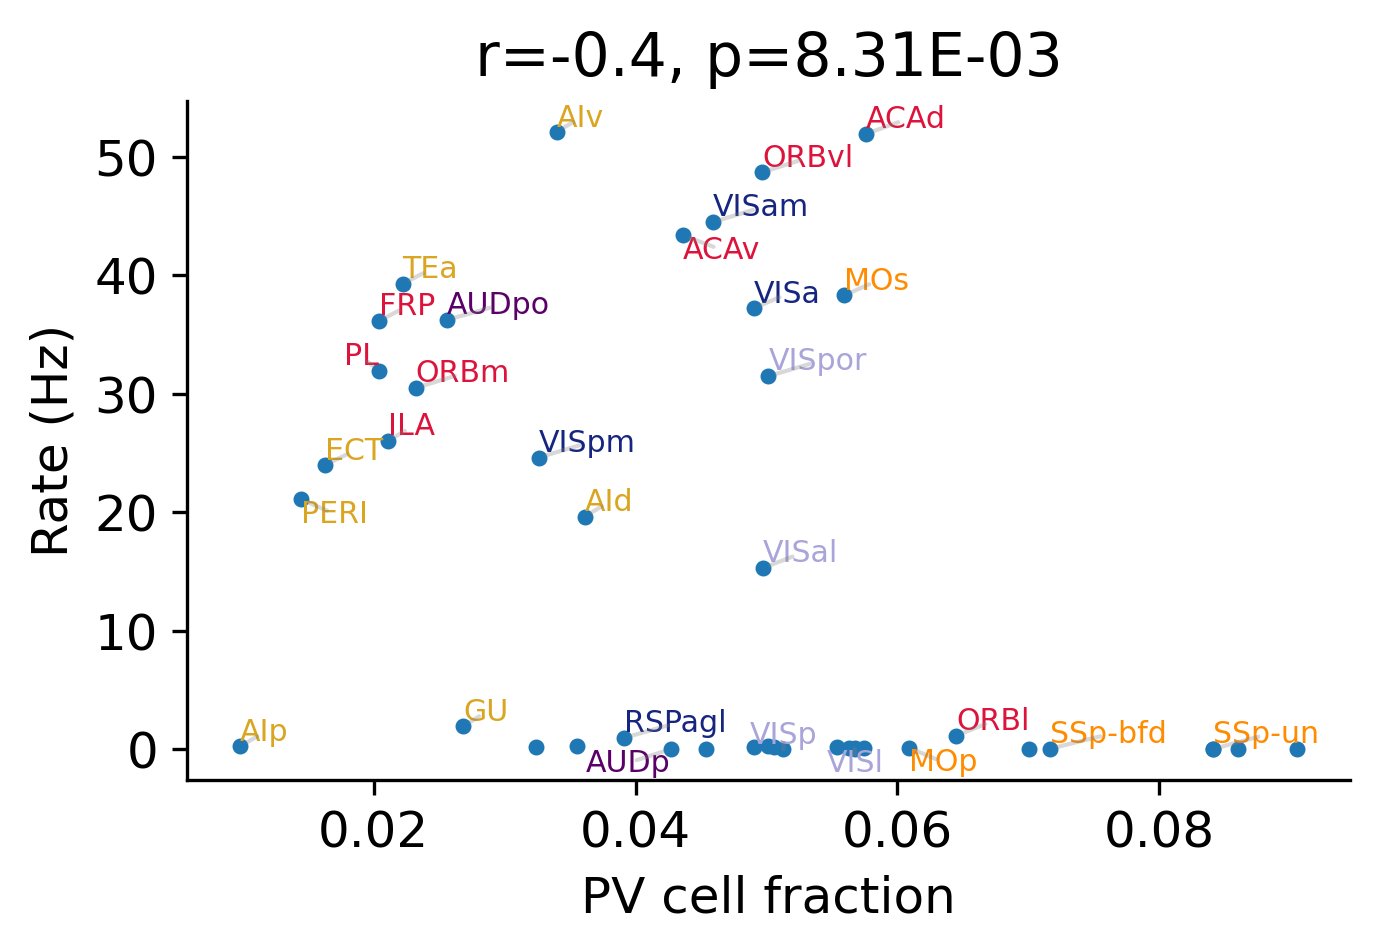

In [61]:
ROIlist_A1 = [1,26,30,31,36, 38]
# ROIlist_A1 = [1,21,26,30,31, 38]
print([area_list[i] for i in ROIlist_A1])
plotAreaList_A1 = [i+1 for i in ROIlist_A1]  # VISp stimulus
# plot firing rates for sample areas
plotDynamics(model_A1, plotAreaList_A1, 'FR', True, 2, (5,3), 12, True, 'makeFigures/dynamicsPlotModelA1.svg')
PVHierDfModelA1 = generatePVHierDf(model_A1, hierarchy_df, rawPV_df)
noLabelAreas = ['SSp-ll','SSp-ul','SSp-n','SSp-m','SSp-tr','VISli','VISpl','VISrl','RSPd','AUDv','SSs']
plotFRvsHiernotebook(model_A1, PVHierDfModelA1, True, True, noLabelAreas, None, 8, (5,3), 12, True, 'makeFigures/FRvsHiernotebookModelA1.svg')

# make plot of raw pv vs firing rate
noLabelAreasPV = ['SSp-ll','SSp-ul','SSp-n','SSp-m','SSp-tr','VISli','VISpl','VISrl','RSPd','AUDv','SSs','AUDd','RSPv','VISC']
plotFRvsrawPVnotebook(model_A1, rawPV_df, True, True, noLabelAreasPV, None, 8, (5,3), 12, True, 'makeFigures/FRvsrawPVnotebookA1.svg')

In [62]:

# panel 1: plot the no LR model, with vs without local inhibition
# panel 2: plot the LR model, with vs without local inhibition vs without long range to inhibition.
# panel 3: in ISN regime, plot the no LR model, with vs without local inhibition, need noise
# panel 4: in ISN regime, plot the LR model, with vs without local inhibition vs without long range to inhibition, need noise

# supp 1: in ISN regime, the local network is bistable.

In [63]:
def makePcomp(modelList, labelList, yRange, vsPV, annotation_adjust, addLegend, showLabel, noLabelAreas, dotSize, figureSize, fontSize, saveFig, fileName):

    fig = plt.figure(figsize=figureSize, dpi=300, facecolor='w', edgecolor='k')
    plt.rcParams.update({'font.size': fontSize})

    for model, label in zip(modelList, labelList):
        div = model.parameters['div']
        div_name_list = model.parameters['div_name_list']
        div_color_list = model.parameters['div_color_list']
        PVHierDf = generatePVHierDf(model, hierarchy_df, rawPV_df)
        if not vsPV:
            # plot FR vs hierarchy
            plt.scatter(PVHierDf['hierarchy'], PVHierDf['persistentact'],
                    s=dotSize, label=label)
        else:
            # plot FR vs PV
            plt.scatter(PVHierDf['PVdensity'], PVHierDf['persistentact'],
                    s=dotSize, label=label)
        ax = plt.gca()
        
        # add annotation text
        if showLabel:
            texts = []
            xPos = []
            yPos = []
            for i in range(len(PVHierDf)):
                acr = PVHierDf['Acronym'][i]
                if acr in model.area_list:
                    for div_name, div_color in zip(div_name_list, div_color_list):
                        if acr in div[div_name] and acr not in noLabelAreas:
                            xPos += PVHierDf['hierarchy'][i]
                            yPos += PVHierDf['persistentact'][i]
                            texts += [ax.text(PVHierDf['hierarchy'][i],
                                            PVHierDf['persistentact'][i], acr,
                                            color=div_color, fontsize=fontSize*0.6)]
                            
            # # use adjust library to adjust the position of annotations.
            if annotation_adjust:
                adjust_text(texts, xPos, yPos,
                            ax=ax, precision=0.001,
                            arrowprops=dict(arrowstyle='-', color='gray', alpha=.3))

    if yRange:
        plt.ylim(yRange) # leave enough space for annotation.

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if addLegend:
        ax.legend(loc='upper left', bbox_to_anchor=(0, 1.12), borderaxespad=0.,  fontsize=fontSize*0.75, frameon=False)
    
    if not vsPV:
        plt.xlabel('Hierarchy')
    else:
        plt.xlabel('PV cell fraction')
    plt.ylabel('Rate (Hz)')
    
    # plt.title('r=' + str(round(corr, 2)) + ', p=' + f"{pvalue:.2E}")
    # print(f"{pvalue:.2E}")

    # save figure
    if saveFig:
        plt.savefig('figure/' + fileName, dpi=300, bbox_inches='tight',transparent=True)
    # plt.savefig('figure/neurondensity_grad.png',dpi=80,bbox_inches='tight')

    # PVHierDf = generatePVHierDf(modelname, hierarchy_df, rawPV_df)
    # plotFRvsHiernotebook(modelname, PVHierDf, True, True, noLabelAreas, yRange, 8, (5,3), 12, True, saveFigName)

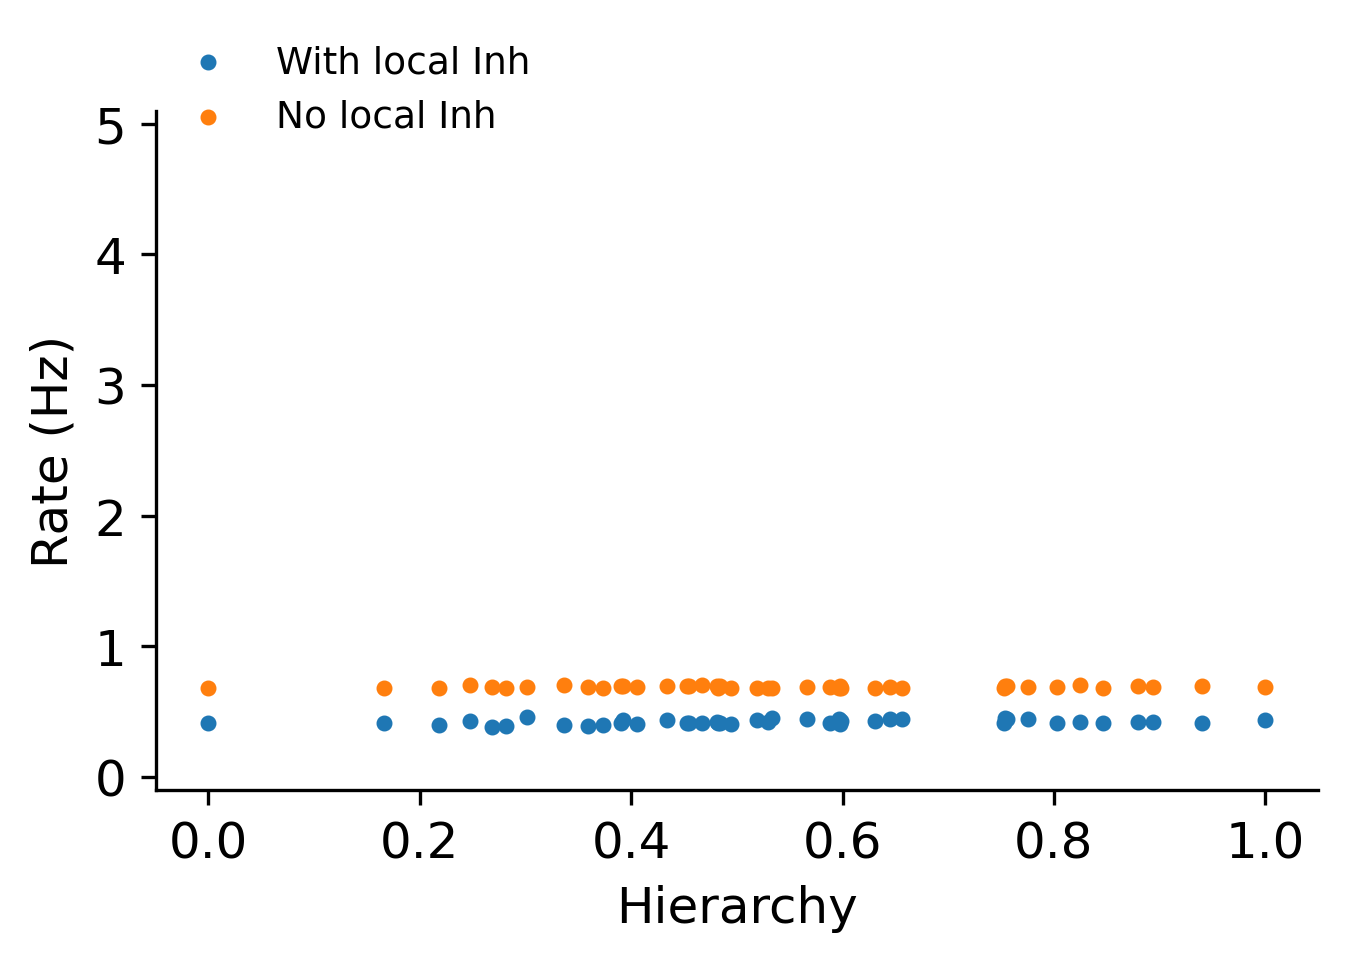

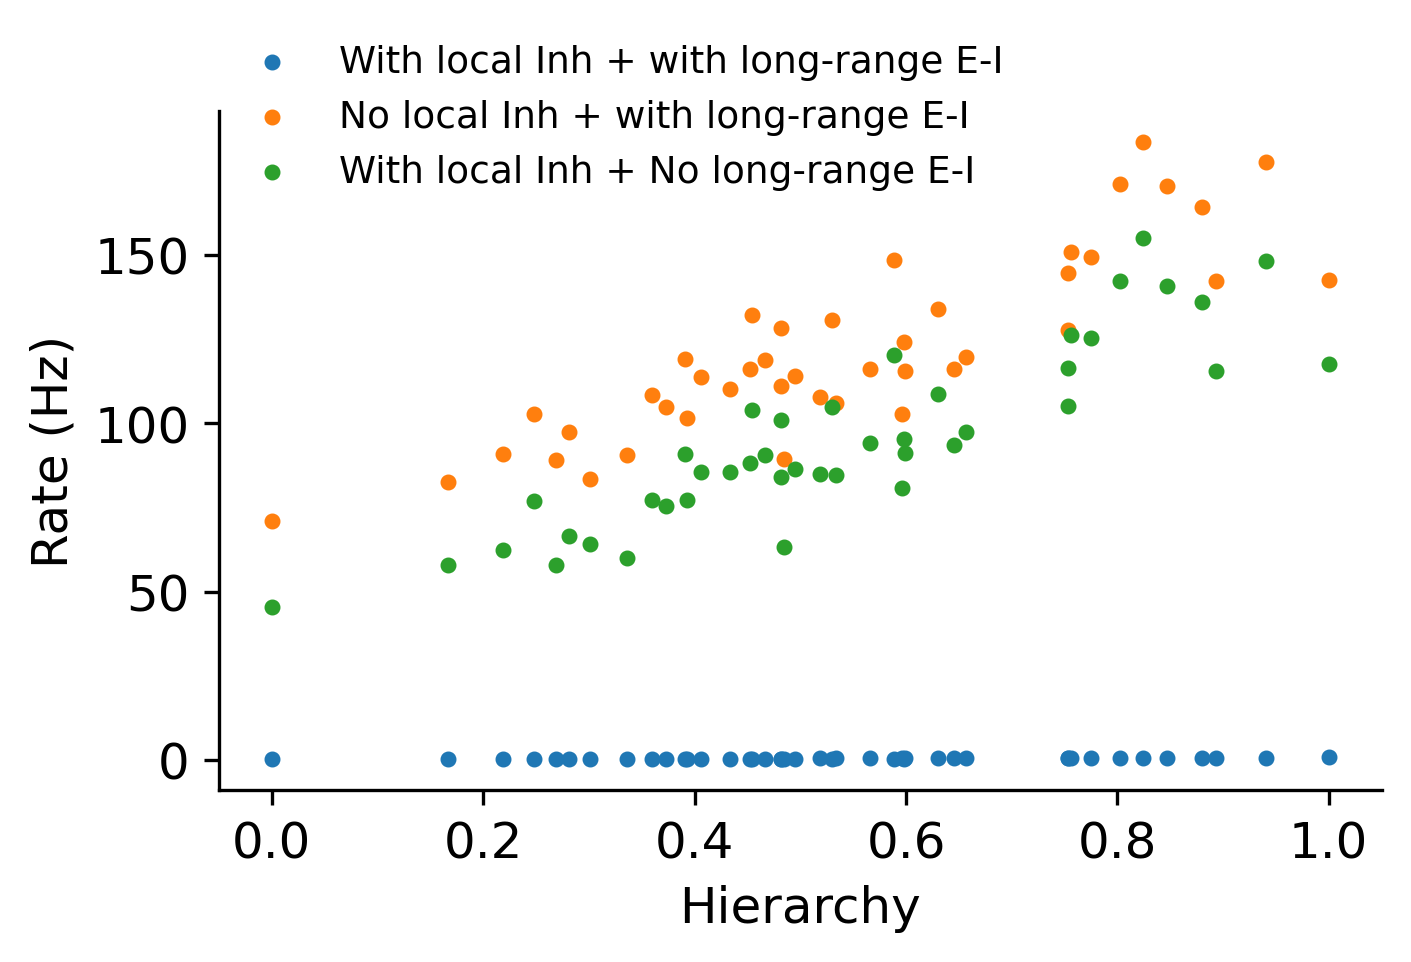

In [64]:
#load model with inhibitory stablizing regime simulations. and make plots
with open('results/model_V1_noLR.pkl', 'rb') as f:
    model_base_noLR = pickle.load(f)

with open('results/model_V1_noLR_noInh.pkl', 'rb') as f:
    model_base_noLR_noInh = pickle.load(f)

with open('results/model_V1_LR.pkl', 'rb') as f:
    model_base_LR = pickle.load(f)

with open('results/model_V1_LR_nolocalInh.pkl', 'rb') as f:
    model_base_LR_nolocalInh = pickle.load(f)

with open('results/model_V1_LR_noLRInh.pkl', 'rb') as f:
    model_base_LR_noLRInh = pickle.load(f)


noLabelAreas =  ['SSp-ll','SSp-ul','SSp-n','SSp-m','SSp-tr','VISli','VISpl','VISrl','RSPd','AUDv','SSs',
                 'SSp-un','VISl','RSPv','RSPagl','GU','ECT','AId','VISpm','TEa','VISpor','VISam','VISal']
makePcomp([model_base_noLR, model_base_noLR_noInh], ['With local Inh','No local Inh'], [-0.1,5.1], False,  False, True, False, noLabelAreas, 8, (5,3), 12, True, 'ISN/base_noLR_comp.pdf')
makePcomp([model_base_LR,model_base_LR_nolocalInh, model_base_LR_noLRInh], 
          ['With local Inh + with long-range E-I','No local Inh + with long-range E-I', 'With local Inh + No long-range E-I'], None, False, False,True, False, noLabelAreas, 8, (5,3), 12, True, 'ISN/base_LR_comp.pdf')



def makeP(modelname, yRange, noLabelAreas, saveFigName):
    PVHierDf = generatePVHierDf(modelname, hierarchy_df, rawPV_df)
    plotFRvsHiernotebook(modelname, PVHierDf, True, True, noLabelAreas, yRange, 8, (5,3), 12, True, saveFigName)

# makeP(model_base_noLR, [-0.5,4.5], noLabelAreas, 'ISN/base_noLR.pdf')
# makeP(model_base_noLR_noInh, [-0.5,4.5],noLabelAreas, 'ISN/base_noLR_noInh.pdf')
# makeP(model_base_LR, [-0.5,4.5],noLabelAreas, 'ISN/base_LR.pdf')
# makeP(model_base_LR_noLRInh, [-0.5,170], noLabelAreas, 'ISN/base_LR_noLRInh.pdf')


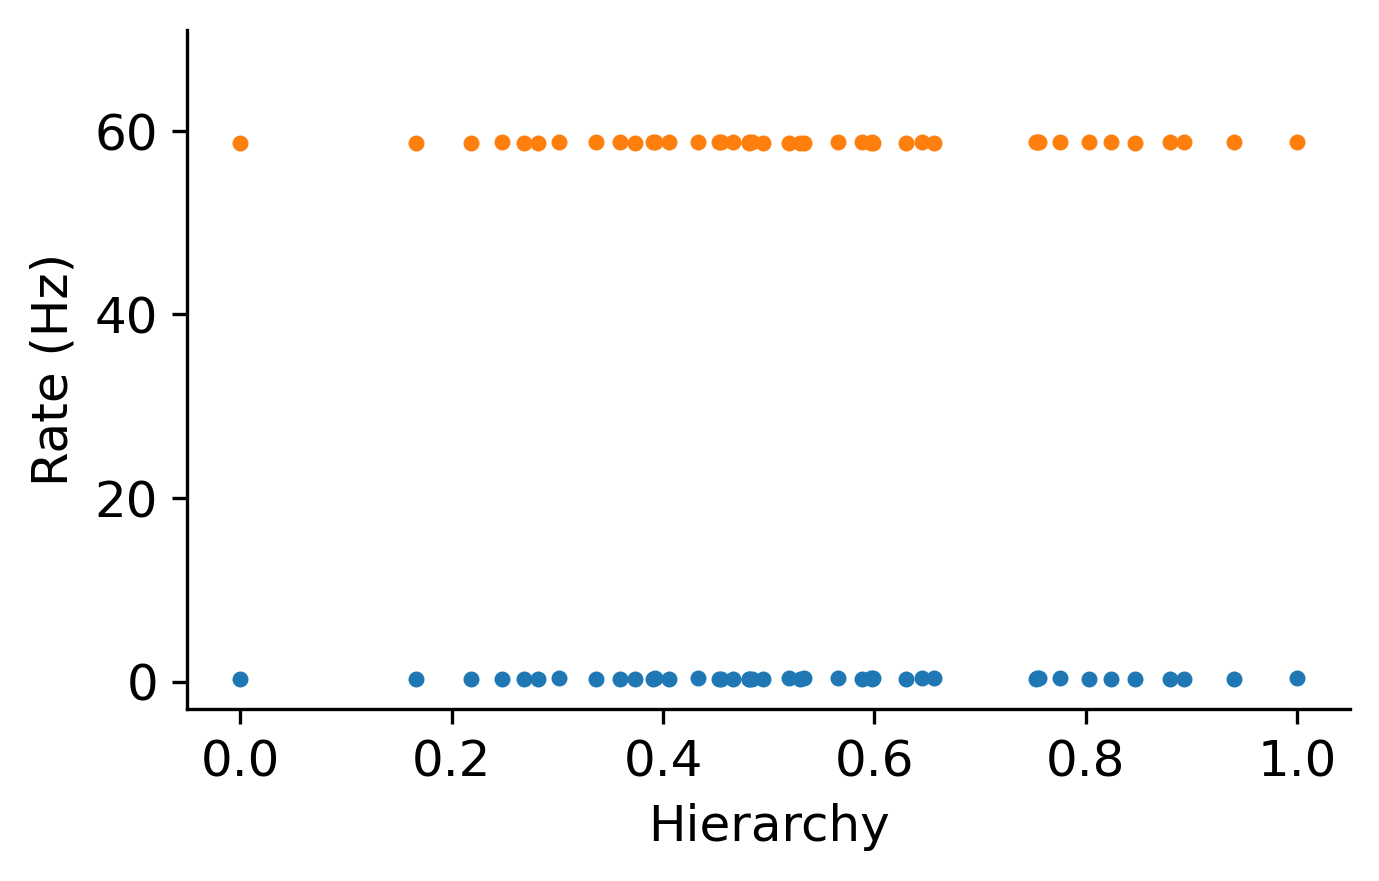

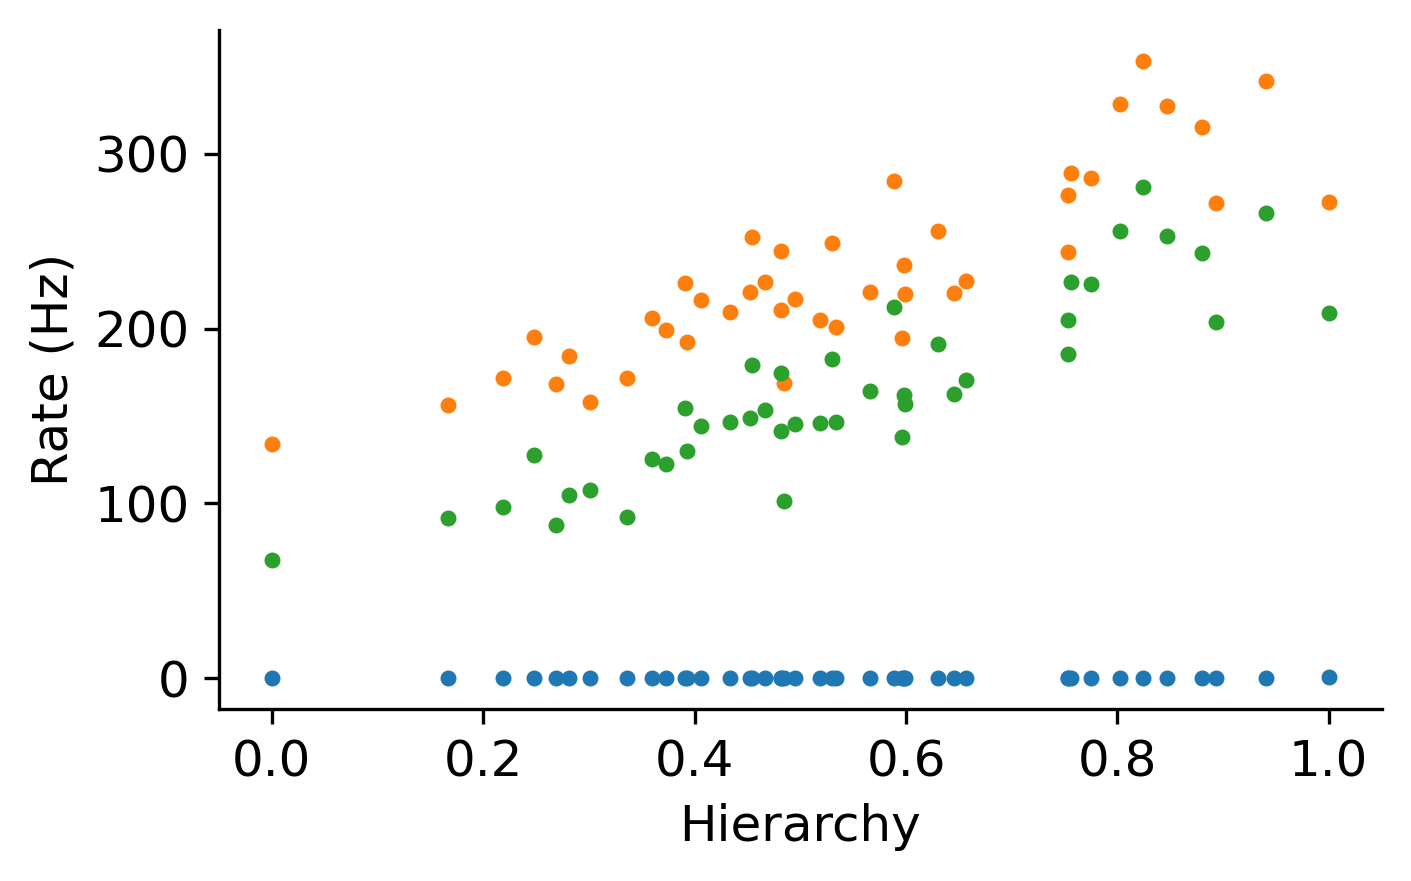

In [65]:
#load model with inhibitory stablizing regime simulations. and make plots
with open('results/model_V1_noLR_ISN.pkl', 'rb') as f:
    model_base_noLR_ISN = pickle.load(f)

with open('results/model_V1_noLR_noInh_ISN.pkl', 'rb') as f:
    model_base_noLR_noInh_ISN = pickle.load(f)

with open('results/model_V1_LR_ISN.pkl', 'rb') as f:
    model_base_LR_ISN = pickle.load(f)

with open('results/model_V1_LR_ISN_nolocalInh.pkl', 'rb') as f:
    model_base_LR_ISN_nolocalInh = pickle.load(f)

with open('results/model_V1_LR_ISN_noLRInh.pkl', 'rb') as f:
    model_base_LR_ISN_noLRInh = pickle.load(f)


noLabelAreas =  ['SSp-ll','SSp-ul','SSp-n','SSp-m','SSp-tr','VISli','VISpl','VISrl','RSPd','AUDv','SSs',
                 'SSp-un','VISl','RSPv','RSPagl','GU','ECT','AId','VISpm','TEa','VISpor','VISam','VISal']
makePcomp([model_base_noLR_ISN, model_base_noLR_noInh_ISN], ['With local Inh','No local Inh'], [-3,71], False, False, False,  False, noLabelAreas, 8, (5,3), 12, True, 'ISN/base_noLR_ISN_comp.pdf')
makePcomp([model_base_LR_ISN,model_base_LR_ISN_nolocalInh, model_base_LR_ISN_noLRInh], ['With local Inh + with LR Inh','No local Inh + with LR Inh', 'With local Inh + No LR Inh'], None, False, False, False, False, noLabelAreas, 8, (5,3), 12, True, 'ISN/base_LR_ISN_comp.pdf')




2.37E-02


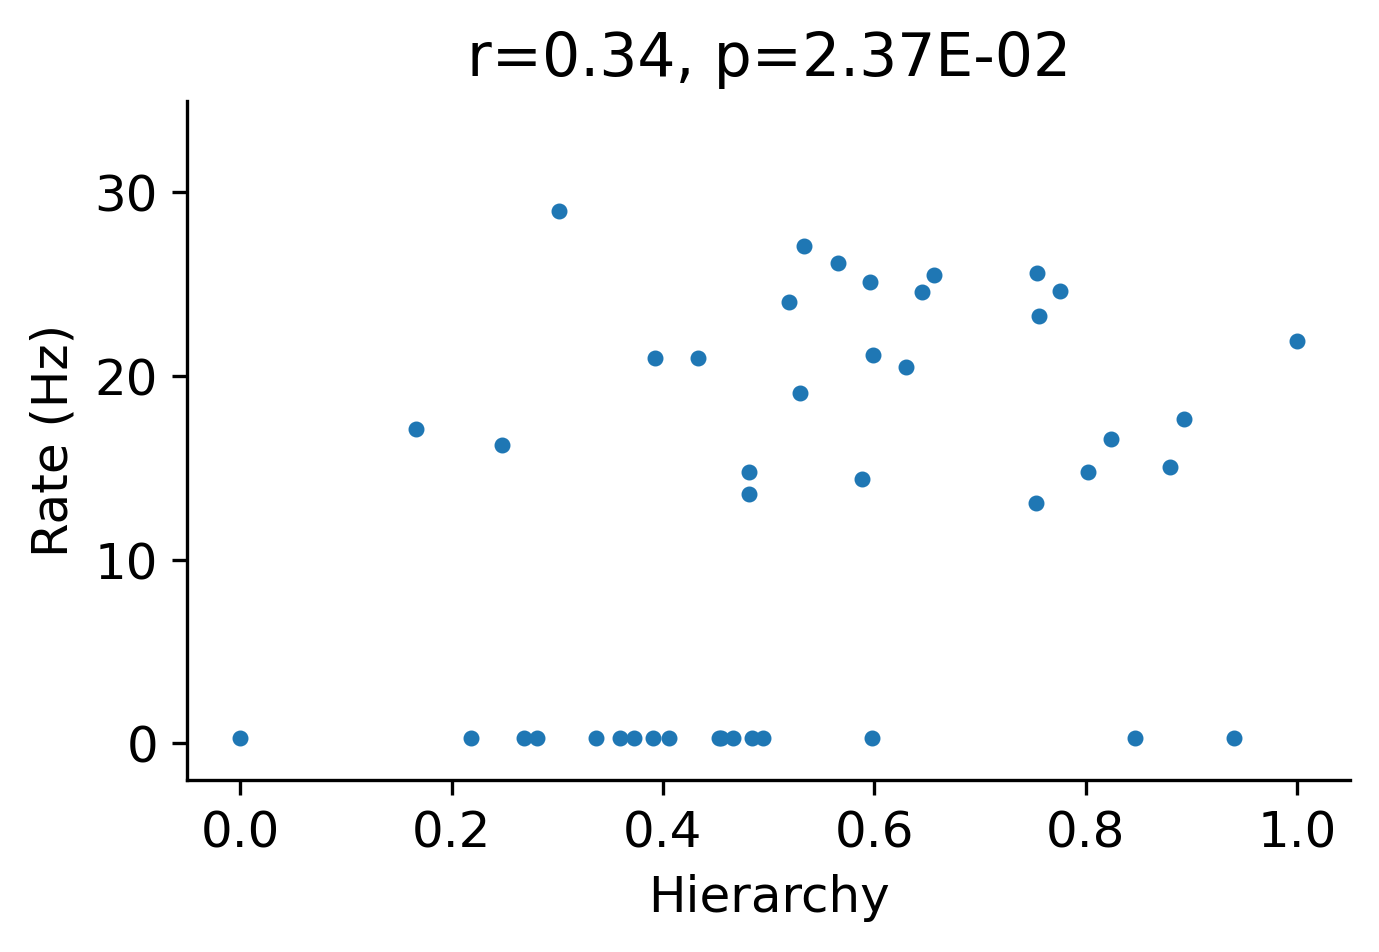

In [66]:
# bistablity plot
with open('results/model_V1_noLR_ISN_bistable.pkl', 'rb') as f:
    model_noLR_ISN_bistable = pickle.load(f)
# noLabelAreasPV = ['SSp-ll','SSp-ul','SSp-n','SSp-m','SSp-tr','VISli','VISpl','VISrl','RSPd','AUDv','SSs','AUDd','RSPv','VISC', 
                #   'ECT', 'FRP', 'VISpm', 'VISal','VISpor','AUDp','ACAd']
# noLabelAreas = ['SSp-ll','SSp-ul','SSp-n','SSp-m','SSp-tr','VISli','VISpl','VISrl','RSPd','AUDv','SSs','AUDd','RSPv', 
#                   'ECT', 'FRP', 'VISpm', 'VISal','VISpor','AUDp','ACAd']
# plotFRvsrawPVnotebook(model_noLR_ISN_bistable, rawPV_df, True, True, noLabelAreasPV, [-2,35], 8, (5,3), 12, True, 'ISN/V1_bistable.pdf')
makeP(model_noLR_ISN_bistable, [-2,35], area_list, 'ISN/V1_bistable.pdf')

2.25E-11


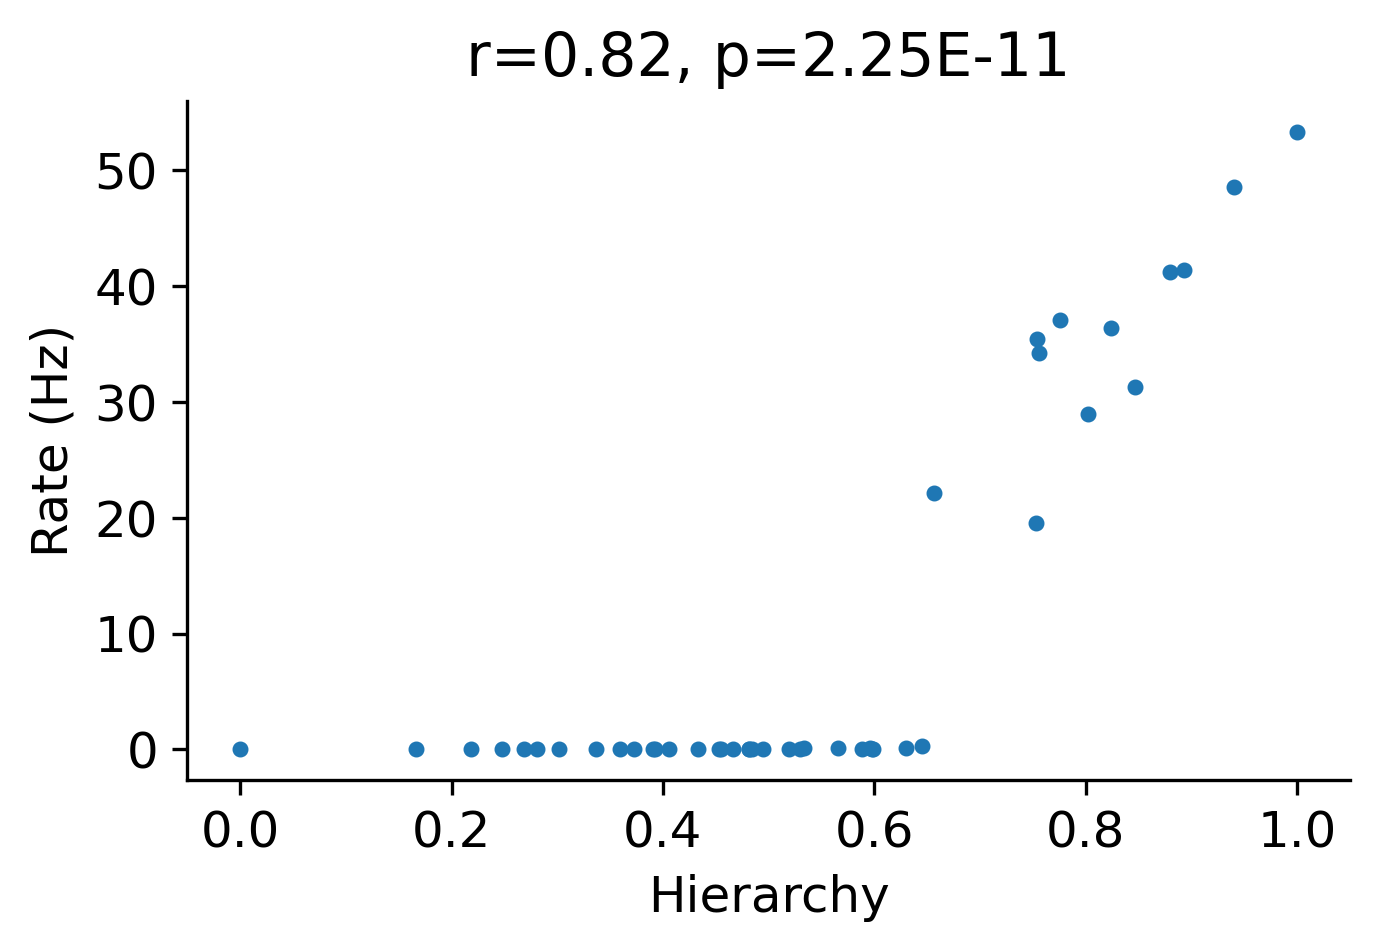

In [67]:
# plot the LR network with ISN
with open('results/model_V1_ISN.pkl', 'rb') as f:
    model_V1_ISN = pickle.load(f)
noLabelAreas =  ['SSp-ll','SSp-ul','SSp-n','SSp-m','SSp-tr','VISli','VISpl','VISrl','RSPd','AUDv','SSs',
                 'SSp-un','VISl','RSPv','RSPagl','GU','ECT','AId','VISpm','TEa','VISpor','VISam','VISal']
makeP(model_V1_ISN, None, area_list, 'ISN/V1_ISN.pdf')

1.33E-15


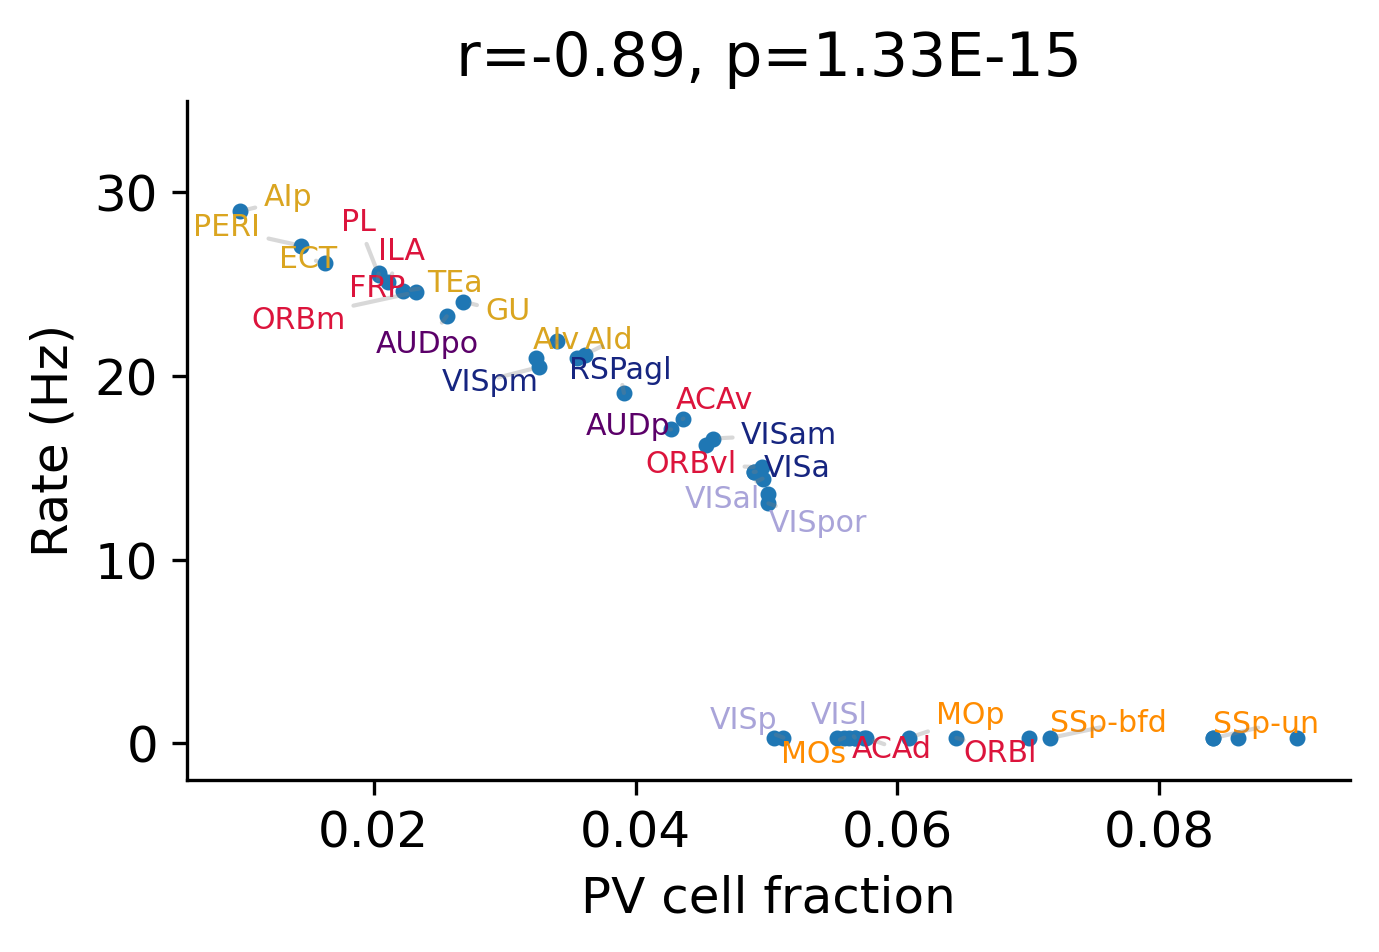

In [68]:
# bistablity plot
with open('results/model_V1_noLR_ISN_bistable.pkl', 'rb') as f:
    model_noLR_ISN_bistable = pickle.load(f)
# noLabelAreasPV = ['SSp-ll','SSp-ul','SSp-n','SSp-m','SSp-tr','VISli','VISpl','VISrl','RSPd','AUDv','SSs','AUDd','RSPv','VISC', 
                #   'ECT', 'FRP', 'VISpm', 'VISal','VISpor','AUDp','ACAd']
# noLabelAreas = ['SSp-ll','SSp-ul','SSp-n','SSp-m','SSp-tr','VISli','VISpl','VISrl','RSPd','AUDv','SSs','AUDd','RSPv', 
#                   'ECT', 'FRP', 'VISpm', 'VISal','VISpor','AUDp','ACAd']
plotFRvsrawPVnotebook(model_noLR_ISN_bistable, rawPV_df, True, True, noLabelAreasPV, [-2,35], 8, (5,3), 12, True, 'ISN/V1_bistable_PV.pdf')
# makeP(model_noLR_ISN_bistable, [-2,35], area_list, 'ISN/V1_bistable.pdf')